# OCOM510M Data Science: Assessment 2

Student ID:

## 1. Aims, objectives and plan
Although we have already stated what is required, please formally state the aims and objectives of the project in your own words. 100-200 words.

Please demonstrate how you have conducted the project with a simple Gantt chart.

## 2. Understanding the case study

###  Case study analysis
State the key points that you found in the case and how you intend to deal with them appropriately to address the client's needs. (You can include more than four points.) 200-300 words.

1.
1. 
1. 
1. 



## 🧠 Problem Definition

An insurance company wants to leverage its historical claim data to predict whether a claim is fraudulent or genuine. The goal is to develop a predictive model that can **flag potential fraud cases for referral**, minimizing both:

- **False Positives** (referring genuine claims, which causes customer loss and stress)
- **False Negatives** (failing to detect fraudulent claims, which leads to financial loss)

A balanced and unbiased model is required, ideally achieving a **balanced error rate close to 5%**.

The business also seeks to quantify the **financial impact of model prediction errors**, particularly the cost associated with **losing customers (FP)** and **paying fraudulent claims (FN)**. This will be done using a pricing model based on average claim value, claim rate, and company overhead.

---

## 🔧 Techniques Used

### 1. Logistic Regression (Baseline Classification Model)

- A simple, interpretable, and widely-used model for binary classification.
- Outputs probability scores that allow threshold tuning for better trade-offs between false positives and false negatives.
- Used to establish a baseline for performance.
- Evaluation metrics include confusion matrix, precision, recall, F1-score, and ROC-AUC.

### 2. Random Forest Classifier (Ensemble Model)

- A powerful tree-based ensemble method that handles non-linear patterns and mixed data types well.
- Less prone to overfitting compared to individual decision trees.
- Can manage imbalanced datasets with built-in support for class weighting.
- Provides feature importance scores for interpretability.
- Performance is evaluated using the same metrics as Logistic Regression, with a focus on minimizing business impact through cost analysis of false positives and false negatives.



## 3. Pre-processing applied

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Merging, pivoting and melting, if necessary
- Preparing the labels appropriately, if necessary
- Dealing with missing values (imputation, filtering) without leaking, if necessary
- Dealing with duplicate values, if necessary
- Scaling, without leaking, if necessary
- Dealing with correlation and collinearity, if necessary
- Variance analysis, if necessary
- Appropriate feature selection such as RFE, if necessary
- Appropriate feature extraction, if necessary
- Identifying and dealing with class imbalance, if necessary
- Identifying and dealing with outliers, if necessary
- Categorical and numerical encoding if necessary
- Other pre-processing 

In [79]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from IPython.display import display
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder , StandardScaler , MinMaxScaler , PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report , precision_recall_curve , accuracy_score , average_precision_score ,f1_score,roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve , StratifiedKFold , cross_val_predict , GridSearchCV , cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, f1_score, precision_recall_curve,
                            make_scorer, roc_curve, average_precision_score , auc)
from sklearn.calibration import calibration_curve
from joblib import parallel_backend
import time
from sklearn.feature_selection import SelectFromModel



### Read & Display Raw Data

In [2]:
raw_tc_df = pd.read_csv('./TrainData/Train_Claim.csv')
raw_td_df = pd.read_csv('./TrainData/Train_Demographics.csv')
raw_tp_df = pd.read_csv('./TrainData/Train_Policy.csv')
raw_tv_df = pd.read_csv('./TrainData/Train_Vehicle.csv')
raw_t_df = pd.read_csv('./TrainData/Traindata_with_Target.csv')

display(raw_tc_df.head())
display(raw_td_df.head())
display(raw_tp_df.head())
display(raw_tv_df.head())
display(raw_t_df.head())


,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481


,CustomerID,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country
0,Cust10000,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India
1,Cust10001,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India
2,Cust10002,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India
3,Cust10003,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India
4,Cust10004,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India


,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,CustomerID
0,110122,328,2014-10-17,State3,250/500,1000,1406.91,0,husband,Cust1001
1,110125,256,1990-05-25,State1,250/500,2000,1415.74,6000000,unmarried,Cust1004
2,110126,228,2014-06-06,State1,500/1000,1000,1583.91,6000000,unmarried,Cust1005
3,110127,256,2006-10-12,State3,250/500,1000,1351.10,0,unmarried,Cust1006
4,110128,137,2000-06-04,State2,250/500,1000,1333.35,0,husband,Cust1007


,CustomerID,VehicleAttribute,VehicleAttributeDetails
0,Cust20179,VehicleID,Vehicle8898
1,Cust21384,VehicleModel,Malibu
2,Cust33335,VehicleMake,Toyota
3,Cust27118,VehicleModel,Neon
4,Cust13038,VehicleID,Vehicle30212


,CustomerID,ReportedFraud
0,Cust20065,N
1,Cust37589,N
2,Cust24312,N
3,Cust5493,Y
4,Cust7704,Y


### Merging, pivoting and melting, if necessary

In [3]:
# Checkig if CustomerId is Repeating i.e value_count > 1 , to see if we need to Pivot the dataframe
display('Train Claim' , raw_tc_df['CustomerID'].value_counts()[lambda x : x>1])
display('Train Demographics',raw_td_df['CustomerID'].value_counts()[lambda x : x >1])
display('Train Policy',raw_tp_df['CustomerID'].value_counts()[lambda x : x > 1])
display('Train Vehicle',raw_tv_df['CustomerID'].value_counts()[lambda x : x > 1])


'Train Claim'

Series([], Name: count, dtype: int64)

'Train Demographics'

Series([], Name: count, dtype: int64)

'Train Policy'

Series([], Name: count, dtype: int64)

'Train Vehicle'

CustomerID
Cust20179    4
Cust23045    4
Cust3818     4
Cust7461     4
Cust16944    4
            ..
Cust30090    4
Cust9783     4
Cust20478    4
Cust35879    4
Cust15237    4
Name: count, Length: 28836, dtype: int64

#### **Pivoting** Concluded from above
Only in `train_vehicle` table customerId are repeating 

In [4]:
# Pivot Train Vehicle Table 
pvt_tv_df = raw_tv_df.pivot_table(index='CustomerID',columns='VehicleAttribute',values='VehicleAttributeDetails',aggfunc='first').reset_index()

# Check null values
pvt_tv_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    28836 non-null  object
 1   VehicleID     28836 non-null  object
 2   VehicleMake   28836 non-null  object
 3   VehicleModel  28836 non-null  object
 4   VehicleYOM    28836 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


In [5]:
# Look Info to understand non-nulls and Dtype

display(raw_tc_df.info())
display(raw_td_df.info())
display(raw_tp_df.info())
display(pvt_tv_df.info())
display(raw_t_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CustomerID             28836 non-null  object
 1   DateOfIncident         28836 non-null  object
 2   TypeOfIncident         28836 non-null  object
 3   TypeOfCollission       28836 non-null  object
 4   SeverityOfIncident     28836 non-null  object
 5   AuthoritiesContacted   26144 non-null  object
 6   IncidentState          28836 non-null  object
 7   IncidentCity           28836 non-null  object
 8   IncidentAddress        28836 non-null  object
 9   IncidentTime           28836 non-null  int64 
 10  NumberOfVehicles       28836 non-null  int64 
 11  PropertyDamage         28836 non-null  object
 12  BodilyInjuries         28836 non-null  int64 
 13  Witnesses              28836 non-null  object
 14  PoliceReport           28836 non-null  object
 15  AmountOfTotalClaim 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CustomerID             28836 non-null  object
 1   InsuredAge             28836 non-null  int64 
 2   InsuredZipCode         28836 non-null  int64 
 3   InsuredGender          28806 non-null  object
 4   InsuredEducationLevel  28836 non-null  object
 5   InsuredOccupation      28836 non-null  object
 6   InsuredHobbies         28836 non-null  object
 7   CapitalGains           28836 non-null  int64 
 8   CapitalLoss            28836 non-null  int64 
 9   Country                28834 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   InsurancePolicyNumber       28836 non-null  int64  
 1   CustomerLoyaltyPeriod       28836 non-null  int64  
 2   DateOfPolicyCoverage        28836 non-null  object 
 3   InsurancePolicyState        28836 non-null  object 
 4   Policy_CombinedSingleLimit  28836 non-null  object 
 5   Policy_Deductible           28836 non-null  int64  
 6   PolicyAnnualPremium         28836 non-null  float64
 7   UmbrellaLimit               28836 non-null  int64  
 8   InsuredRelationship         28836 non-null  object 
 9   CustomerID                  28836 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 2.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    28836 non-null  object
 1   VehicleID     28836 non-null  object
 2   VehicleMake   28836 non-null  object
 3   VehicleModel  28836 non-null  object
 4   VehicleYOM    28836 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     28836 non-null  object
 1   ReportedFraud  28836 non-null  object
dtypes: object(2)
memory usage: 450.7+ KB


None

#### Merging
All Tables have `28836` records and `no null` values in `any` table

In [6]:
## Merge all 5 Tables on CustomerId
print('Train Claims Shape:' , raw_tc_df.shape)
print('Train Demographic Shape:' , raw_td_df.shape)
print('Train Policy Shape:' , raw_tp_df.shape)
print('Train Vehicle Shape:' , pvt_tv_df.shape)
print('Train Target Shape:' , raw_t_df.shape)

merged_df:DataFrame = reduce(lambda left,right : pd.merge(left,right,how='inner',on='CustomerID'), [raw_tc_df,raw_td_df,raw_tp_df,pvt_tv_df,raw_t_df])

print('Merged Table Shape:' , merged_df.shape)
print('Total Columns in Merged is equal to adition of all coulmns from individual tables ? ', (raw_tc_df.shape[1] +  raw_td_df.shape[1] + raw_tp_df.shape[1] +  pvt_tv_df.shape[1] + raw_t_df.shape[1] - 4 ) == merged_df.shape[1])

pd.set_option('display.max_columns', 100)
merged_df.head()

Train Claims Shape: (28836, 19)
Train Demographic Shape: (28836, 10)
Train Policy Shape: (28836, 10)
Train Vehicle Shape: (28836, 5)
Train Target Shape: (28836, 2)
Merged Table Shape: (28836, 42)
Total Columns in Merged is equal to adition of all coulmns from individual tables ?  True


,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India,119121,49,1998-10-25,State1,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,N
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India,119122,114,2000-11-15,State1,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,N
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India,119123,167,2001-02-12,State3,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,N
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India,119124,190,2005-04-11,State2,500/1000,722,1337.60,0,own-child,Vehicle37363,Volkswagen,Jetta,2003,N
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India,119125,115,1996-10-25,State2,100/300,500,1353.73,4279863,unmarried,Vehicle28633,Toyota,CRV,2010,N


In [7]:
# Look for missing and duplicate
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   DateOfIncident              28836 non-null  object 
 2   TypeOfIncident              28836 non-null  object 
 3   TypeOfCollission            28836 non-null  object 
 4   SeverityOfIncident          28836 non-null  object 
 5   AuthoritiesContacted        26144 non-null  object 
 6   IncidentState               28836 non-null  object 
 7   IncidentCity                28836 non-null  object 
 8   IncidentAddress             28836 non-null  object 
 9   IncidentTime                28836 non-null  int64  
 10  NumberOfVehicles            28836 non-null  int64  
 11  PropertyDamage              28836 non-null  object 
 12  BodilyInjuries              28836 non-null  int64  
 13  Witnesses                   288

### Dealing with duplicate values

In [8]:
print('Before Deduplicate' , merged_df.shape)
merged_df.drop_duplicates(inplace=True)
print('After Deduplicate' , merged_df.shape)

Before Deduplicate (28836, 42)
After Deduplicate (28836, 42)


### Preparing the labels appropriately

In [9]:
print(merged_df['ReportedFraud'].value_counts(dropna=False))
print(merged_df['ReportedFraud'].value_counts(normalize=True))

ReportedFraud
N    21051
Y     7785
Name: count, dtype: int64
ReportedFraud
N    0.730025
Y    0.269975
Name: proportion, dtype: float64


#### Above results suggest Target label is `imbalanced` with `Y is ~26% and N is ~73%` and no missing value

In [10]:
# Encode the Labels into binary 
merged_df['ReportedFraud'] = merged_df['ReportedFraud'].map({'N' : 0 , 'Y' : 1})
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   DateOfIncident              28836 non-null  object 
 2   TypeOfIncident              28836 non-null  object 
 3   TypeOfCollission            28836 non-null  object 
 4   SeverityOfIncident          28836 non-null  object 
 5   AuthoritiesContacted        26144 non-null  object 
 6   IncidentState               28836 non-null  object 
 7   IncidentCity                28836 non-null  object 
 8   IncidentAddress             28836 non-null  object 
 9   IncidentTime                28836 non-null  int64  
 10  NumberOfVehicles            28836 non-null  int64  
 11  PropertyDamage              28836 non-null  object 
 12  BodilyInjuries              28836 non-null  int64  
 13  Witnesses                   288

### Dealing with datatype conversions
 - DateOfIncident from Object  to Date Format
 - Witnesses from Object  to int64
 - DateOfPolicyCoverage from Object  to Date Format
 - Policy_CombinedSingleLimit Split into 2 features
 - VehicleYOM from Object  to int64

In [11]:
class ColumnTypeConverter:
    def __init__(self, column_name, target_type='datetime', errors='coerce'):
        self.column_name = column_name
        self.target_type = target_type
        self.errors = errors

    def transform(self, df):
        if self.column_name not in df.columns:
            raise ValueError(f"Column '{self.column_name}' not found in DataFrame.")
        
        original_non_nulls = df[self.column_name].notna().sum()

        if self.target_type == 'datetime':
            df[self.column_name] = pd.to_datetime(df[self.column_name], errors=self.errors)
        elif self.target_type == 'int64':
            df[self.column_name] = pd.to_numeric(df[self.column_name], errors=self.errors).astype('Int64')
        elif self.target_type == 'float64':
            df[self.column_name] = pd.to_numeric(df[self.column_name], errors=self.errors).astype('float64')
        else:
            raise ValueError("target_type must be one of: 'datetime', 'int64', 'float64'")

        converted_non_nulls = df[self.column_name].notna().sum()
        failed_conversions = original_non_nulls - converted_non_nulls

        print(f"[{self.column_name}] Conversion Summary to '{self.target_type}':")
        print(f"✅ Successfully converted: {converted_non_nulls}")
        print(f"❌ Failed conversions (NaT or NaN): {failed_conversions}")
        
        return df


In [12]:
dateOfIncident = ColumnTypeConverter('DateOfIncident',target_type='datetime',errors='coerce')
dateOfPolicyCoverage = ColumnTypeConverter('DateOfPolicyCoverage',target_type='datetime',errors='coerce')
witnesses = ColumnTypeConverter('Witnesses',target_type='float64',errors='coerce')
vehicleYom = ColumnTypeConverter('VehicleYOM',target_type='int64',errors='coerce')
amountOfTotalClaim = ColumnTypeConverter('AmountOfTotalClaim',target_type='float64',errors='coerce')

dateOfIncident.transform(merged_df)
dateOfPolicyCoverage.transform(merged_df)
witnesses.transform(merged_df)
vehicleYom.transform(merged_df)
amountOfTotalClaim.transform(merged_df)
merged_df.info()

[DateOfIncident] Conversion Summary to 'datetime':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[DateOfPolicyCoverage] Conversion Summary to 'datetime':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[Witnesses] Conversion Summary to 'float64':
✅ Successfully converted: 28790
❌ Failed conversions (NaT or NaN): 46
[VehicleYOM] Conversion Summary to 'int64':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[AmountOfTotalClaim] Conversion Summary to 'float64':
✅ Successfully converted: 28786
❌ Failed conversions (NaT or NaN): 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CustomerID                  28836 non-null  object        
 1   DateOfIncident              28836 non-null  datetime64[ns]
 2   TypeOfIncident              2883

##### ✅ Successful Conversions

- **DateOfIncident** and **DateOfPolicyCoverage**:  
  Fully converted to `datetime64[ns]`.

- **VehicleYOM**:  
  All values successfully converted to `Int64`.

- **Witnesses**:  
  Mostly successful; **46 missing** (`NaT` or `NaN`).


### 🕒 Date Feature Engineering

To enhance model performance and extract meaningful temporal patterns from the `DateOfIncident` and `DateOfPolicyCoverage` columns, the following date-based features were engineered:

#### ✅ Extracted from `DateOfIncident`
| Feature Name            | Description                                   |
|-------------------------|-----------------------------------------------|
| `IncidentYear`          | Year in which the incident occurred           |
| `IncidentMonth`         | Month (1–12) of the incident                  |
| `IncidentDay`           | Day of the month when the incident occurred   |
| `IncidentWeekDay`       | Day of the week (0=Monday, 6=Sunday)          |
| `IncidentWeek`          | ISO calendar week number                      |
| `IncidentIsOnWeekend`   | Binary flag indicating if the incident happened on a weekend (`1` = Saturday/Sunday) |

#### 🔁 Derived from `DateOfIncident` and `DateOfPolicyCoverage`
| Feature Name             | Description                                        |
|--------------------------|----------------------------------------------------|
| `DaysSincePolicyStart`   | Number of days between policy coverage start date and the date of incident. Reflects policy age at time of incident. |


#### 🗑️ Dropping Raw Date Columns

After extracting meaningful features from the datetime columns `DateOfIncident` and `DateOfPolicyCoverage`, the original columns were no longer needed.

#### ❌ Dropped Columns
| Column                 | Reason for Removal                                      |
|------------------------|---------------------------------------------------------|
| `DateOfIncident`       | Replaced by derived features like `IncidentMonth`, `IncidentWeekday`, and `DaysSincePolicyStart` |
| `DateOfPolicyCoverage` | Used only to compute `DaysSincePolicyStart`            |



In [13]:
merged_df['IncidentYear'] = merged_df['DateOfIncident'].dt.year
merged_df['IncidentMonth'] = merged_df['DateOfIncident'].dt.month
merged_df['IncidentDay'] = merged_df['DateOfIncident'].dt.day
merged_df['IncidentWeekDay'] = merged_df['DateOfIncident'].dt.weekday
merged_df['IncidentWeek'] = merged_df['DateOfIncident'].dt.isocalendar().week
merged_df['IncidentIsOnWeekend'] = merged_df['IncidentWeekDay'].isin([5,6]).astype(int)
merged_df['DaysSincePolicyStart'] = (merged_df['DateOfIncident'] - merged_df['DateOfPolicyCoverage']).dt.days

merged_df.drop(columns=['DateOfIncident','DateOfPolicyCoverage'],inplace=True)

In [14]:
merged_df.head()

,CustomerID,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud,IncidentYear,IncidentMonth,IncidentDay,IncidentWeekDay,IncidentWeek,IncidentIsOnWeekend,DaysSincePolicyStart
0,Cust10000,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0.0,?,65501.0,13417,6071,46013,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India,119121,49,State1,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,0,2015,2,3,1,6,0,5945
1,Cust10001,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1.0,YES,61382.0,15560,5919,39903,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India,119122,114,State1,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,0,2015,2,2,0,6,0,5192
2,Cust10002,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3.0,NO,66755.0,11630,11630,43495,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India,119123,167,State3,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,0,2015,1,15,3,3,0,5085
3,Cust10003,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3.0,NO,66243.0,12003,12003,42237,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India,119124,190,State2,500/1000,722,1337.60,0,own-child,Vehicle37363,Volkswagen,Jetta,2003,0,2015,1,19,0,4,0,3570
4,Cust10004,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1.0,YES,53544.0,8829,7234,37481,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India,119125,115,State2,100/300,500,1353.73,4279863,unmarried,Vehicle28633,Toyota,CRV,2010,0,2015,1,9,4,2,0,6650


#### ✅ Features Engineering from `Policy_CombinedSingleLimit`

The original column was split into two new float columns:

| Column            | Non-Null Count | Dtype    | Description                         |
|------------------|----------------|----------|-------------------------------------|
| `LimitPerPerson` | 28836          | float64  | Insurance limit per person          |
| `LimitPerAccident` | 28836        | float64  | Insurance limit per accident        |

- All values successfully converted to `float64`
- No missing values detected
- Original column `Policy_CombinedSingleLimit` was dropped after transformation


In [15]:
# Split Policy_CombinedSingleLimit into 2 columns 
merged_df[['LimitPerPerson', 'LimitPerAccident']] = merged_df['Policy_CombinedSingleLimit'].str.split('/', expand=True).astype(float)
merged_df[['LimitPerPerson', 'LimitPerAccident']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LimitPerPerson    28836 non-null  float64
 1   LimitPerAccident  28836 non-null  float64
dtypes: float64(2)
memory usage: 450.7 KB


### Redundancy Analysis of `AmountOfTotalClaim`

In [16]:
# 1. Calculate total
merged_df['CalculatedTotal'] = (
    merged_df['AmountOfInjuryClaim'] +
    merged_df['AmountOfPropertyClaim'] +
    merged_df['AmountOfVehicleDamage']
)

# 2. Create a boolean mask for rows with all finite values (no NaN or inf)
valid_rows = merged_df[['CalculatedTotal', 'AmountOfTotalClaim']].applymap(np.isfinite).all(axis=1)

# 3. Compare only valid rows using np.isclose
mismatches = merged_df.loc[valid_rows, :][~np.isclose(
    merged_df.loc[valid_rows, 'CalculatedTotal'],
    merged_df.loc[valid_rows, 'AmountOfTotalClaim'],
    rtol=1e-5
)]

# 4. Show results
if mismatches.empty:
    print("✅ All valid rows match — safe to drop `AmountOfTotalClaim`.")
else:
    print(f"⚠️ {len(mismatches)} mismatches found in valid rows.")
    print(mismatches[['AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'AmountOfVehicleDamage',
                      'CalculatedTotal', 'AmountOfTotalClaim']].head())

# 5. Drop columns
# merged_df.drop(columns=['AmountOfTotalClaim', 'CalculatedTotal'], inplace=True)



✅ All valid rows match — safe to drop `AmountOfTotalClaim`.


/var/folders/2q/4h8qwwsx6t5446pyq1l03mjh0000gn/T/ipykernel_41733/2307080109.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  valid_rows = merged_df[['CalculatedTotal', 'AmountOfTotalClaim']].applymap(np.isfinite).all(axis=1)


### 🔧 Feature Engineering: of `AmountOfTotalClaim`

Upon inspection, the feature `AmountOfTotalClaim` was found to be a **linear sum** of the following three features:

- `AmountOfInjuryClaim`
- `AmountOfPropertyClaim`
- `AmountOfVehicleDamage`

We validated this relationship across the dataset:

#### 💡 Decision:
- Since this feature does not provide **new information** and introduces **perfect multicollinearity**, it was **dropped** from the dataset before modeling.


In [17]:
merged_df.drop(columns=['AmountOfTotalClaim', 'CalculatedTotal'], inplace=True)
print('')

#### 🧹 Missing Value Handling Strategy

Based on the attribute documentation for the `CSE9099c` dataset, multiple missing value indicators are used across different columns. Below is a detailed plan to clean and standardize missing values **before modeling**.

---

##### 🔍 Step 1: Replace Custom Missing Indicators

##### 🟨 Demographics
| Column                 | Missing Indicator | Suggested Replacement      |
|------------------------|-------------------|----------------------------|
| `InsuredGender`        | "NA"              | Replace with `'Unknown'`   |
| `Country`              | NaN (2 missing)   | Replace with `'Unknown'`   |

##### 🟦 Policy Information
| Column                | Missing Indicator | Suggested Replacement      |
|-----------------------|-------------------|----------------------------|
| `PolicyAnnualPremium` | `-1`              | Replace with `np.nan`      |
| `TotalCharges`        | `"MISSINGVAL"`    | Replace with `np.nan`      |
| `ContractType`        | `"NA"`            | Replace with `'Unknown'`   |

##### 🟥 Claim Information
| Column                 | Missing Indicator   | Suggested Replacement      |
|----------------------- |---------------------|----------------------------|
| `TypeOfCollission`     | `"?"`               | Replace with `'Unknown'`   |
| `PropertyDamage`       | `"?"`               | Replace with `'Unknown'`   |
| `PoliceReport`         | `"?"`               | Replace with `'Unknown'`   |
| `IncidentTime`         | `-5`                | Replace with `np.nan`      |
| `Witnesses`            | `"MISSINGVALUE"`    | Replace with `np.nan`      |
| `AuthoritiesContacted`  | `Nan`              | Replace with `Unknown`      |

##### 🟪 Vehicle Data
| Column                    | Missing Indicator | Suggested Replacement      |
|---------------------------|-------------------|----------------------------|
| `VehicleAttributeDetails` | `"???"`           | Replace with `'Unknown'`   |
| `Vehiclemake`             | `"???"`           | Replace with `'Unknown'`   |

---




In [18]:

merged_df.replace({
    'InsuredGender': {'NA': 'Unknown'},
    'ContractType': {'NA': 'Unknown'},
    'TypeOfCollission': {'?': 'Unknown'},
    'PropertyDamage': {'?': 'Unknown'},
    'PoliceReport': {'?': 'Unknown'},
    'TotalCharges': {'MISSINGVAL': np.nan},
    'Witnesses': {'MISSINGVALUE': np.nan},
    'VehicleAttributeDetails': {'???': 'Unknown'},
    'VehicleMake':{'???': 'Unknown'}
}, inplace=True)

# Replace numeric placeholder values
merged_df['IncidentTime'] = merged_df['IncidentTime'].replace(-5, np.nan)
merged_df['PolicyAnnualPremium'] = merged_df['PolicyAnnualPremium'].replace(-1, np.nan)

merged_df['AuthoritiesContacted'] = merged_df['AuthoritiesContacted'].fillna('Unknown')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   TypeOfIncident              28836 non-null  object 
 2   TypeOfCollission            28836 non-null  object 
 3   SeverityOfIncident          28836 non-null  object 
 4   AuthoritiesContacted        28836 non-null  object 
 5   IncidentState               28836 non-null  object 
 6   IncidentCity                28836 non-null  object 
 7   IncidentAddress             28836 non-null  object 
 8   IncidentTime                28805 non-null  float64
 9   NumberOfVehicles            28836 non-null  int64  
 10  PropertyDamage              28836 non-null  object 
 11  BodilyInjuries              28836 non-null  int64  
 12  Witnesses                   28790 non-null  float64
 13  PoliceReport                288

#### 🔍 Unique Value Count Analysis

To understand the structure and distribution of values across columns, we calculated the number of unique values in each column using the following code:

#### 🎯 Why This Matters
Analyzing unique value counts helps in:

- **Identifying High-Cardinality Features**
Columns like CustomerID, VehicleID, or IncidentAddress may have thousands of unique values, which are not ideal for one-hot encoding and can increase dimensionality unnecessarily.

- **Spotting Low-Cardinality Categorical Features**
Features with only a few unique values (e.g., Gender, PropertyDamage, PoliceReport) are perfect candidates for one-hot encoding.

- **Detecting Constant or Near-Constant Columns**
Columns with only one unique value offer no variability and can be safely dropped.

In [19]:
# Only do it for dtype =object
unique_counts_df = pd.DataFrame({
    'Column': merged_df.select_dtypes(include='object').columns,
    'UniqueValues': [merged_df[col].nunique(dropna=False) for col in merged_df.select_dtypes(include='object').columns]
}).sort_values(by='UniqueValues', ascending=False)

# Only do it for dtype  not object i.e numeric
unique_numeric_counts_df = pd.DataFrame({
    'Column': merged_df.select_dtypes(exclude='object').columns,
    'UniqueValues': [merged_df[col].nunique(dropna=False) for col in merged_df.select_dtypes(exclude='object').columns]
}).sort_values(by='UniqueValues', ascending=False)

print('Object type' , unique_counts_df)
print('Non Object type' , unique_numeric_counts_df)

Object type                         Column  UniqueValues
0                   CustomerID         28836
18                   VehicleID         28836
7              IncidentAddress          1000
20                VehicleModel            39
13              InsuredHobbies            20
19                 VehicleMake            15
12           InsuredOccupation            14
16  Policy_CombinedSingleLimit             9
5                IncidentState             7
6                 IncidentCity             7
11       InsuredEducationLevel             7
17         InsuredRelationship             6
4         AuthoritiesContacted             5
1               TypeOfIncident             4
2             TypeOfCollission             4
3           SeverityOfIncident             4
15        InsurancePolicyState             3
9                 PoliceReport             3
8               PropertyDamage             3
10               InsuredGender             3
14                     Country             

#### 📊 Unique Value Count Summary

The number of unique values was calculated for each column to guide **feature engineering, encoding decisions, and dimensionality reduction**.

---
| Column                  | Notes (based on earlier unique value counts)                         |
| ----------------------- | -------------------------------------------------------------------- |
| `TypeOfIncident`        | 4 values – ✅ encode                                                  |
| `TypeOfCollission`      | 4 values – ✅ encode                                                  |
| `SeverityOfIncident`    | 4 values – ✅ encode                                                  |
| `AuthoritiesContacted`  | 5 values – ✅ encode                                                  |
| `PropertyDamage`        | 3 values – ✅ encode                                                  |
| `PoliceReport`          | 3 values – ✅ encode                                                  |
| `InsuredGender`         | 3 values – ✅ encode                                                  |
| `InsuredEducationLevel` | 7 values – ✅ encode                                                  |
| `InsuredOccupation`     | 14 values – ✅ encode                                                 |
| `InsuredHobbies`        | 20 values – ✅ encode                                                 |                                                 
| `InsurancePolicyState`  | 3 values – ✅ encode                                                  |
| `InsuredRelationship`   | 6 values – ✅ encode                                                  |
| `VehicleMake`           | 15 values – ⚠️ encode or group (depends on model)                    |
| `VehicleModel`          | 39 values – ⚠️ maybe encode top N, group rest  -- but will leave it for timebeing                      |
| `ReportedFraud`         | 🎯 This is the target — do **not encode**, just map `{‘Y’:1, ‘N’:0}` |


---

### ❌ Constant Features (to be dropped)

| Column           | Unique Values |
|------------------|----------------|
| `IncidentYear`   | 1              |
| `Country`        | 2 ( 2 Unnkown and rest India')              |


### ❌ Hight Cardinality Features (to be dropped)
| Column            | Reason                                                  |
| ----------------- | ------------------------------------------------------- |
| `IncidentAddress` | 1000 unique values — likely not useful for encoding    |
| `CustomerID`  |  High cardinality (28836 values) — drop or treat specially |
| `VehicleID`  | High cardinality (28836 values) — drop or treat specially |



This unique value audit helps decide:
- What to drop
- What to one-hot encode
- What to normalize or transform


In [20]:
## Print Vehicke Make and Model to decide how to group them if needed to be grouped
print(merged_df['VehicleMake'].value_counts())
print(merged_df['VehicleModel'].value_counts())
print(merged_df['InsuredHobbies'].value_counts())

VehicleMake
Saab          2415
Suburu        2313
Nissan        2300
Dodge         2263
Chevrolet     2174
Ford          2158
Accura        2099
BMW           2073
Toyota        1981
Volkswagen    1960
Audi          1952
Jeep          1946
Mercedes      1659
Honda         1493
Unknown         50
Name: count, dtype: int64
VehicleModel
RAM               1344
Wrangler          1261
A3                1102
MDX               1054
Jetta             1037
Neon               928
Pathfinder         919
Passat             888
Legacy             887
92x                859
Malibu             828
95                 820
A5                 812
F150               797
Forrestor          784
Camry              771
Tahoe              736
93                 724
Maxima             722
Grand Cherokee     718
Escape             706
Ultima             698
E400               695
X5                 691
TL                 684
Silverado          668
Fusion             650
Highlander         633
Civic              6

#### Conluded from above will leave grouping VehicalMake and Model as I cant see any natural grouping -- may need to revisit if model struggling from overfitting

#### 🗑️ **Dropped** Irrelevant or High-Cardinality Columns

To reduce noise and avoid overfitting, the following columns were removed:

| Column                    | Reason for Removal                             |
|---------------------------|------------------------------------------------|
| `Policy_CombinedSingleLimit` | Replaced by `LimitPerPerson` and `LimitPerAccident` |
| `CustomerID`             | Unique identifier, not useful for modeling     |
| `InsurancePolicyNumber`  | High-cardinality identifier, non-informative   |
| `VehicleID`              | Unique identifier, adds no predictive value    |
| `IncidentAddress`        | High-cardinality |
| `IncidentYear`           | 1 value |
| `Country`                | 1 value |

In [21]:
merged_df.drop(['Policy_CombinedSingleLimit','CustomerID','InsurancePolicyNumber','VehicleID','IncidentAddress','IncidentYear','Country'] , axis=1,inplace=True)
merged_df.columns
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TypeOfIncident         28836 non-null  object 
 1   TypeOfCollission       28836 non-null  object 
 2   SeverityOfIncident     28836 non-null  object 
 3   AuthoritiesContacted   28836 non-null  object 
 4   IncidentState          28836 non-null  object 
 5   IncidentCity           28836 non-null  object 
 6   IncidentTime           28805 non-null  float64
 7   NumberOfVehicles       28836 non-null  int64  
 8   PropertyDamage         28836 non-null  object 
 9   BodilyInjuries         28836 non-null  int64  
 10  Witnesses              28790 non-null  float64
 11  PoliceReport           28836 non-null  object 
 12  AmountOfInjuryClaim    28836 non-null  int64  
 13  AmountOfPropertyClaim  28836 non-null  int64  
 14  AmountOfVehicleDamage  28836 non-null  int64  
 15  In

### Identifying and dealing with class imbalance

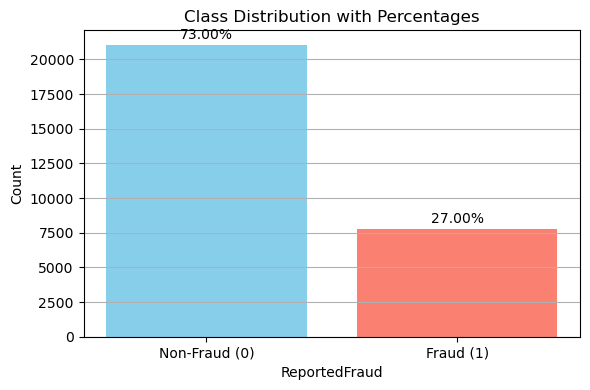

In [22]:

# Class distribution (already mapped to 0/1)
class_counts = merged_df['ReportedFraud'].value_counts()
class_percentages = class_counts / class_counts.sum() * 100

# Bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index.astype(str), class_counts.values, color=['skyblue', 'salmon'])

# Add percentage labels on top of each bar
for bar, percentage in zip(bars, class_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 200, f'{percentage:.2f}%', ha='center', va='bottom')

# Labels and styling
plt.title("Class Distribution with Percentages")
plt.xlabel("ReportedFraud")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Fraud (0)", "Fraud (1)"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 📊 Class Imbalance Analysis

#### 🖼️ Visualization Summary

The bar plot below illustrates the distribution of the target variable `ReportedFraud`:

- **Non-Fraud (0):** 73%
- **Fraud (1):** 27%

Although the classes are not extremely imbalanced (e.g., 95/5), there is still a **moderate imbalance** between fraudulent and non-fraudulent claims.

---

#### 🔍 Interpretation

- The dataset shows **27% fraudulent** and **73% non-fraudulent** claims.
- This imbalance could lead to:
  - A model that is biased toward predicting the majority class (non-fraud)
  - High overall accuracy but **low recall** or **low F1-score** for the fraud class
- Relying solely on accuracy would be misleading in this context.

---

#### 💡 Recommended Solutions

| Strategy                        | Description                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| `class_weight='balanced'`       |b Automatically adjusts the model’s loss to give more importance to the minority class |
| **Stratified Cross-Validation** | Ensures each fold maintains the original class distribution during model evaluation |
| **Precision-Recall Evaluation** | Use metrics like precision, recall, F1-score, and AUC-PR for fair evaluation |


These strategies help in building a model that treats fraud detection with proper attention, even with imbalanced data.


### Outlier Detetction

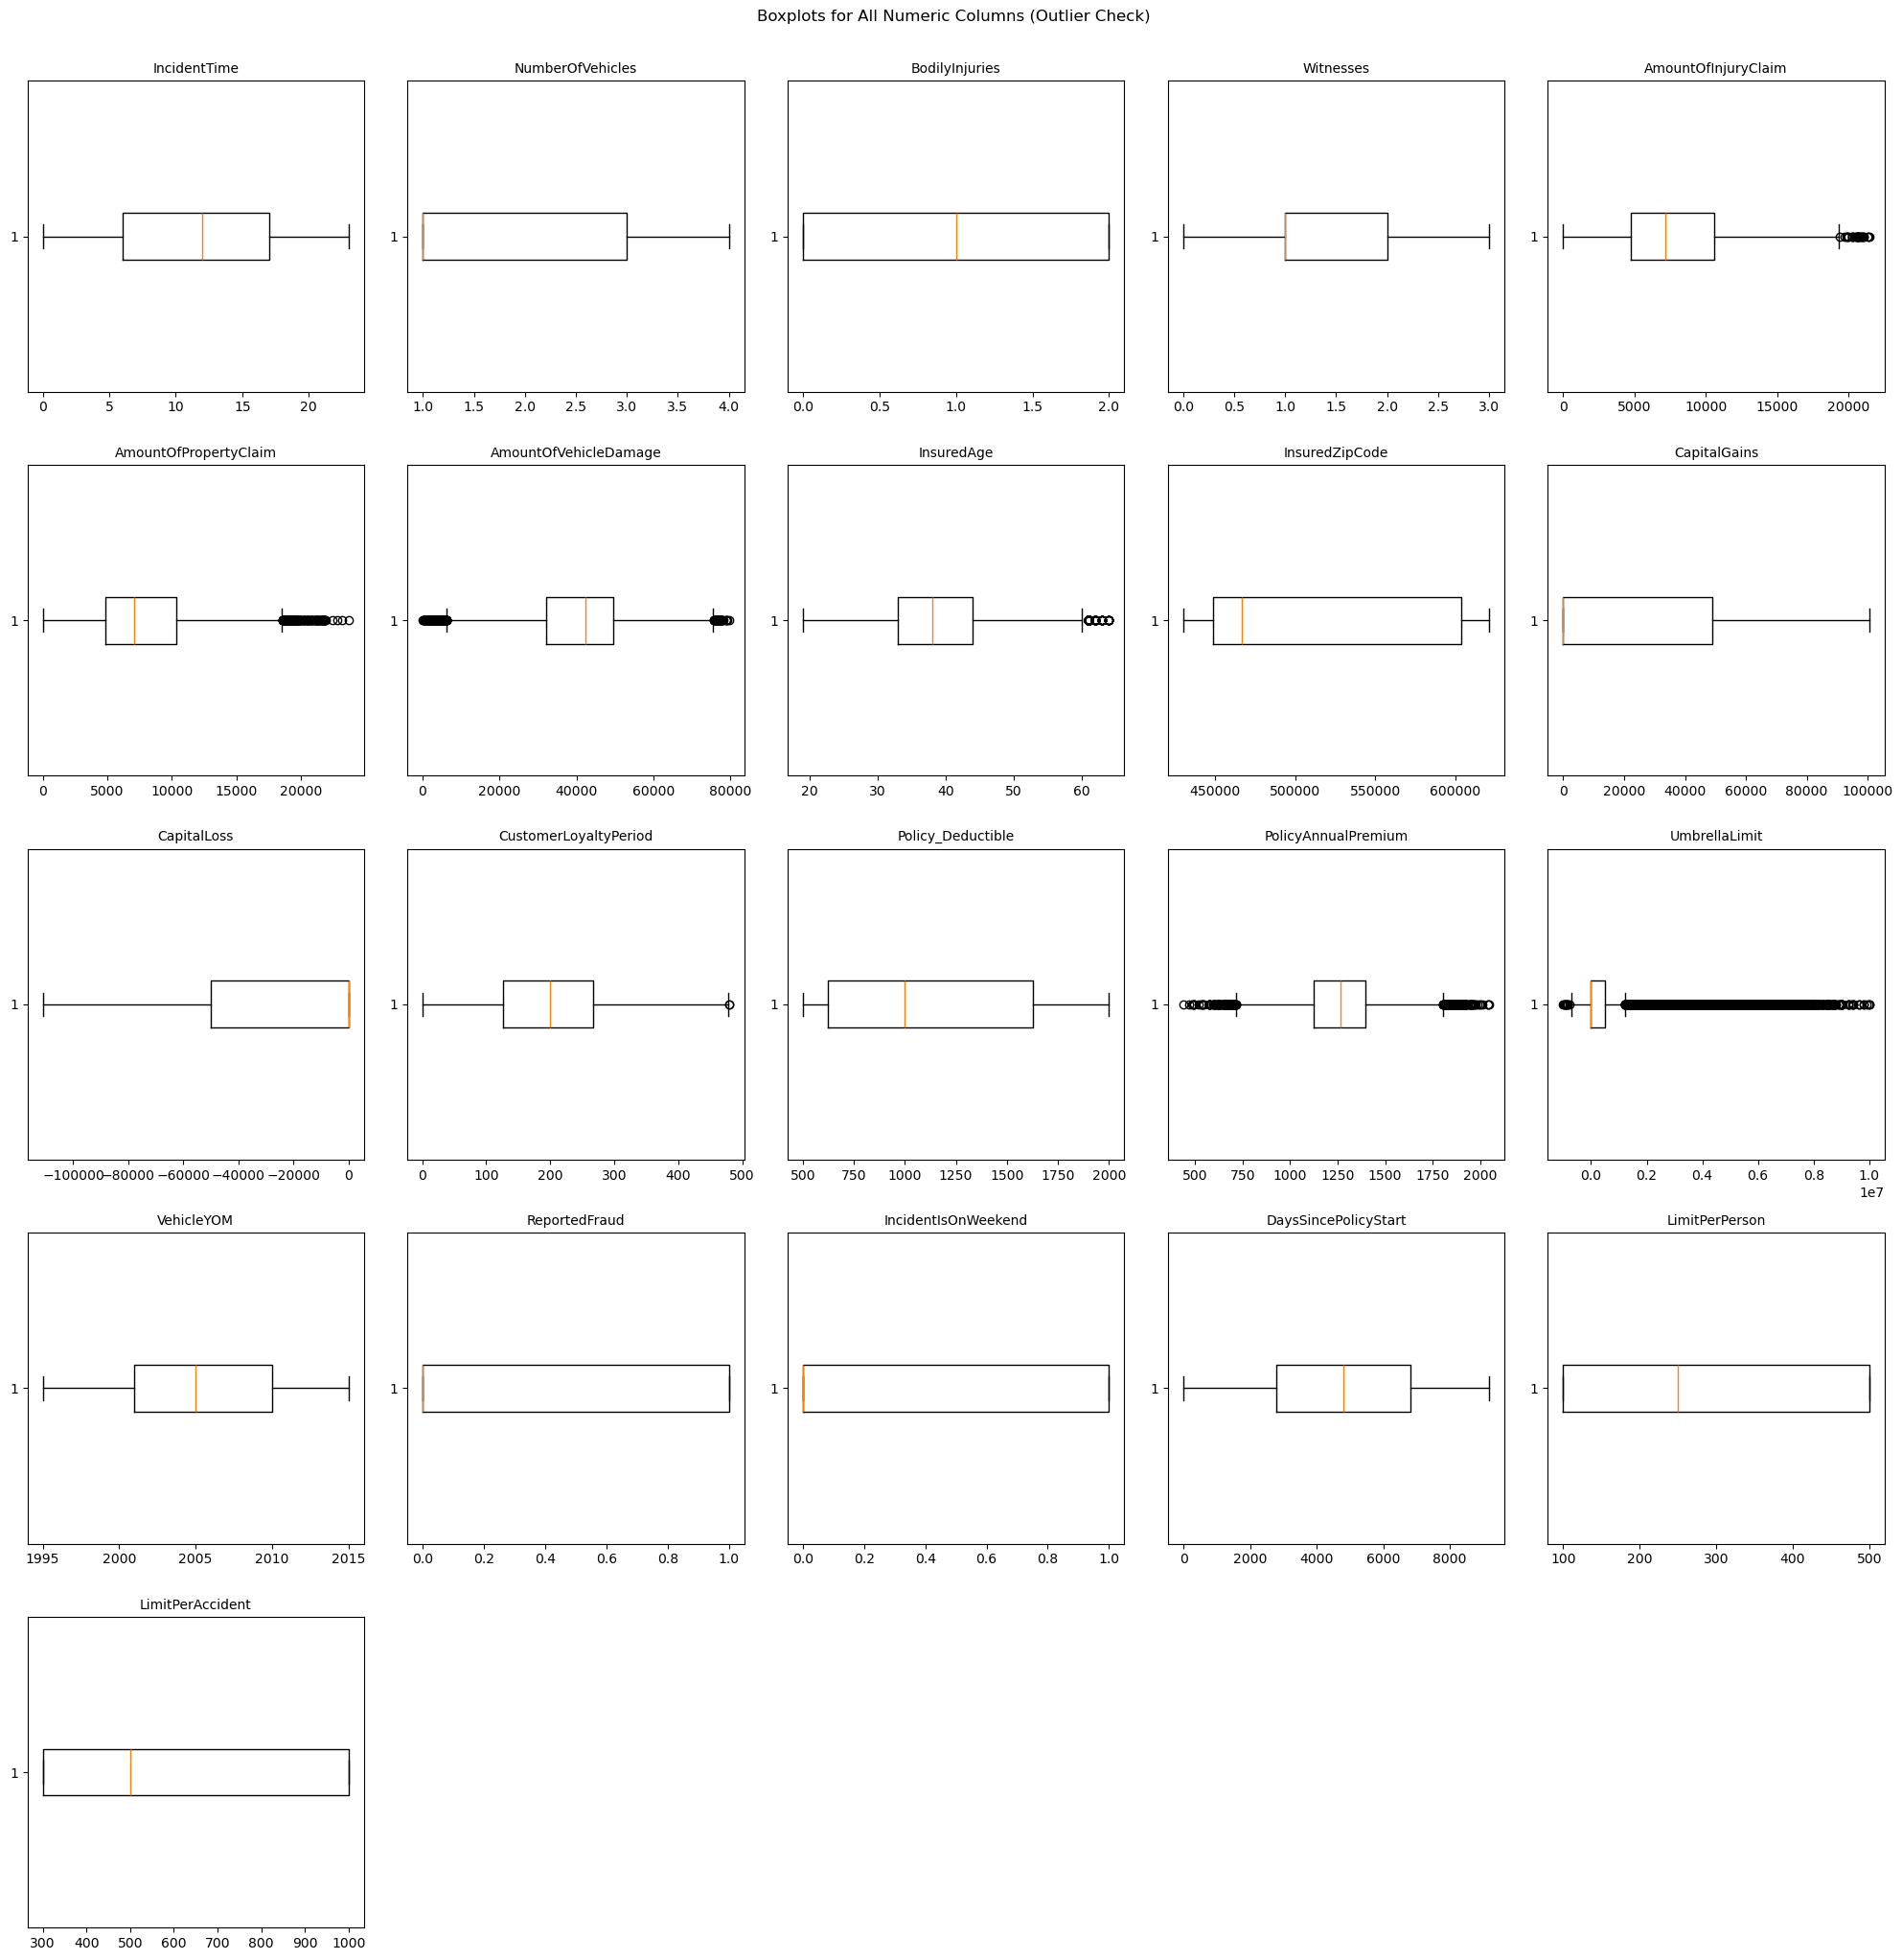

In [23]:
# Select numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64','int64']).columns
n_cols = len(numeric_cols)

# Calculate grid dimensions (rows, cols)
n_rows = int(np.ceil(n_cols / 5))  # 5 columns per row (adjust as needed)
fig, axes = plt.subplots(n_rows, 5, figsize=(20, n_rows * 4))  # Adjust height per row
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot boxplots for each numeric column
for i, col in enumerate(numeric_cols):
    axes[i].boxplot(merged_df[col].dropna(), vert=False)
    axes[i].set_title(col, fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Boxplots for All Numeric Columns (Outlier Check)", y=1.02)
plt.show()

### 📊 Outlier Summary Based on Box Plots (All Sets)

#### 🚨 Clear Outlier (Will Be Addressed):
- **UmbrellaLimit**: Contains values < 0 (logically invalid). These entries will be cleaned or removed.

#### ⚠️ Potential Outliers (Will Be Retained As-Is):

##### From First Set:
- **PolicyAnnualPremium**: Right-skewed with extreme high values.
- **CapitalGains**: Large upper-end values.
- **CapitalLoss**: Deep negative values; retained unless business rules say otherwise.
- **CustomerLoyaltyPeriod**: Some long-tenure customers; assumed valid.
- **AmountOfInjuryClaim**: Heavy right tail with dense outliers; kept for integrity.
- **AmountOfPropertyClaim**: Similar right-skew; retained.
- **AmountOfVehicleDamage**: Wide range and extreme values on both ends; retained.
- **InsuredAge**: Outliers at the high end (60+); assumed valid unless data says otherwise.

#### ✅ No Issues Observed (No Clear Outliers):
- **Policy_Deductible**
- **DaysSincePolicyStart**
- **ReportedFraud** (binary)
- **IncidentIsOnWeekend** (binary)
- **VehicleYOM**
- **IncidentTime**
- **NumberOfVehicles**
- **BodilyInjuries**
- **Witnesses**
- **InsuredZipCode**
- **LimitPerPerson**: Uniform spread, no points beyond whiskers.
- **LimitPerAccident**: Uniform spread, no points beyond whiskers.

#### 📝 Final Decision:
- Only **clear and logically invalid outliers** (e.g., `UmbrellaLimit < 0`) will be addressed.
- All other numerical outliers identified via box plots, including `LimitPerPerson` and `LimitPerAccident`, will be **retained** to preserve real-world variance and avoid over-cleaning.



In [24]:
negative_umbrella_mask = merged_df['UmbrellaLimit'] < 0
print(f"Found {negative_umbrella_mask.sum()} rows with negative UmbrellaLimit to be dropped")
merged_df = merged_df[~negative_umbrella_mask]

Found 34 rows with negative UmbrellaLimit to be dropped


###  Rescaling the attributes
#### Plot Numeric Feature Distributions (Histograms) to infer Scalaing Strategy

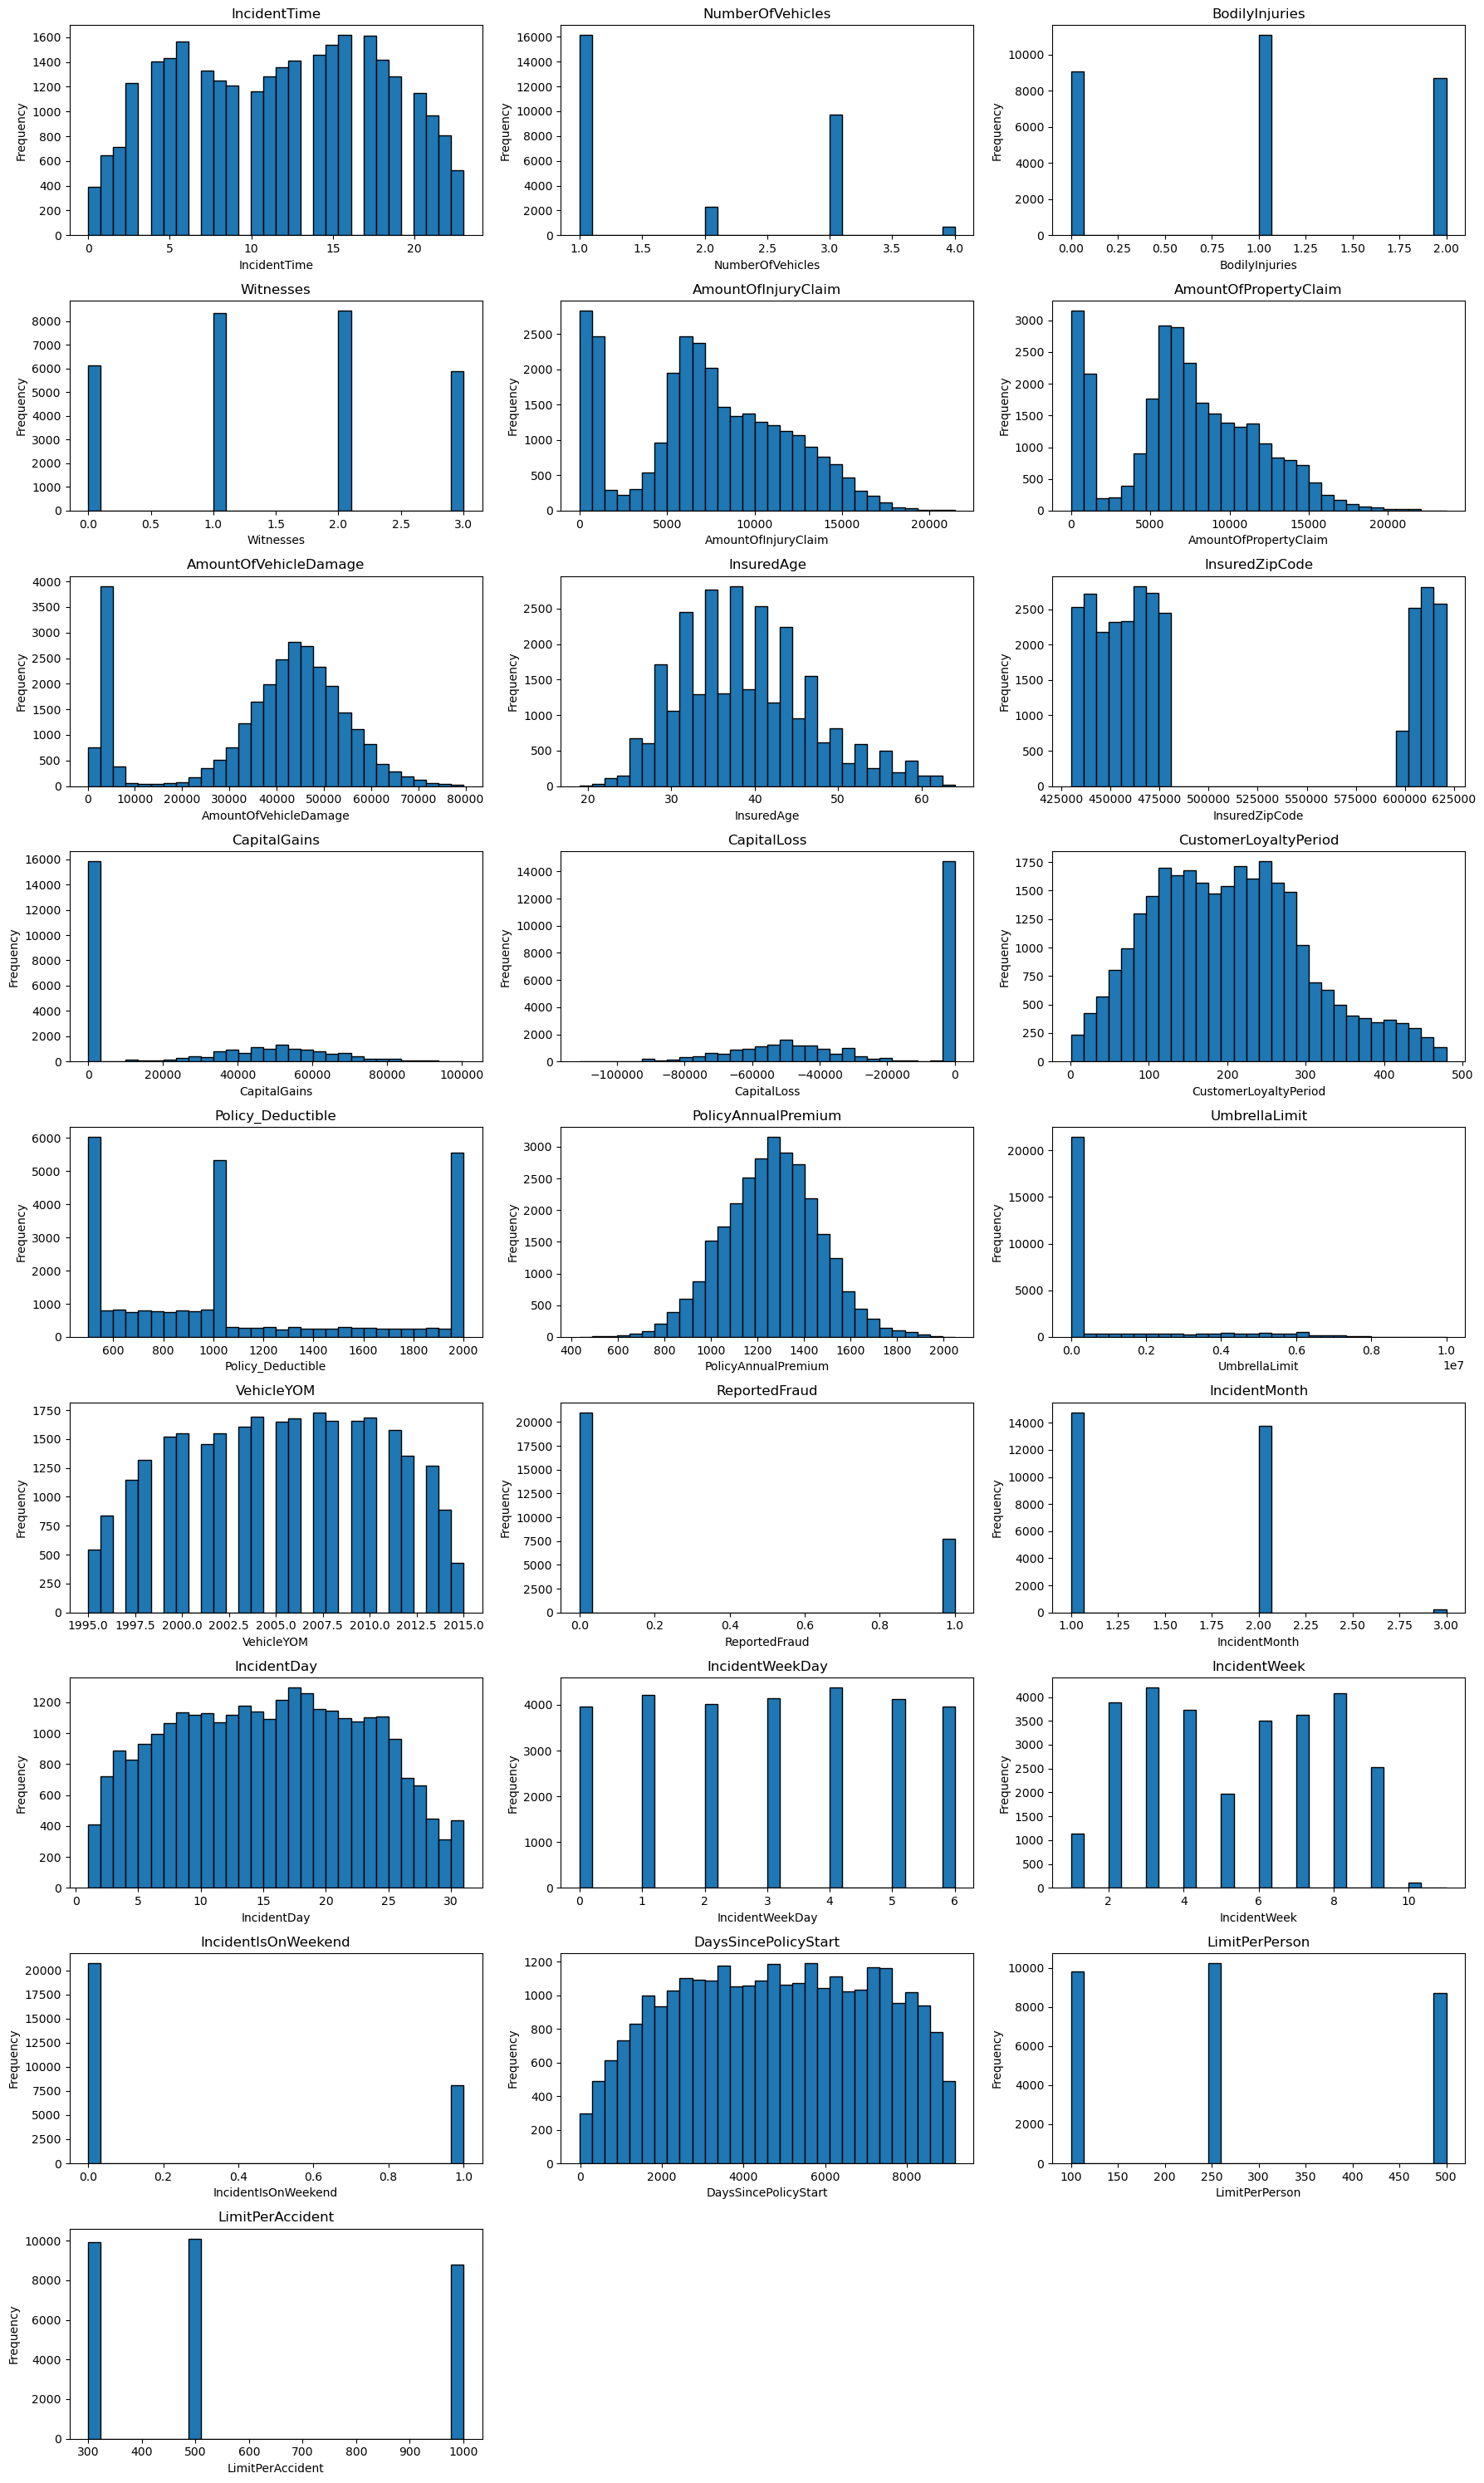

In [25]:

# Select numeric columns only
numeric_columns = merged_df.select_dtypes(include=['int64', 'float64', 'Int64', 'UInt32', 'int32']).columns

fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(18, 30))  # Adjust size as needed
axes = axes.flatten()

# Plot histogram for each numeric column
for i, col in enumerate(numeric_columns):
    axes[i].hist(merged_df[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_ylabel("Frequency")
    axes[i].set_xlabel(col)

# Remove any extra empty plots (if less than 27)
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



#### ⚙️ Feature Scaling Strategy

To ensure consistent model performance and interpretability, numeric features are scaled based on their nature using the following rules:

---


#### ✅ 1. High-Cardinality / Continuous Features → Use `StandardScaler`

These features have wide numeric ranges and many unique values. Standardization helps center and scale them.

| Feature                    | Unique Values |
|----------------------------|----------------|
| `InsurancePolicyNumber`    | 28836          |
| `PolicyAnnualPremium`      | 23852          |
| `AmountOfVehicleDamage`    | 20041          |
| `AmountOfInjuryClaim`      | 11958          |
| `AmountOfPropertyClaim`    | 11785          |
| `DaysSincePolicyStart`     | 7358           |
| `UmbrellaLimit`            | 7089           |
| `Policy_Deductible`        | 1496           |
| `InsuredZipCode`           | 995            |
| `CustomerLoyaltyPeriod`    | 479            |
| `CapitalLoss`              | 354            |
| `CapitalGains`             | 338            |


---

#### 🌗 2. Medium-Cardinality / Bounded Features → Use `MinMaxScaler`

These features are bounded and ordinal but not fully continuous. MinMax scaling preserves range and order.

| Feature              | Unique Values |
|----------------------|----------------|
| `IncidentDay`        | 31             |
| `IncidentTime`       | 25             |
| `VehicleYOM`         | 21             |
| `IncidentWeek`       | 11             |
| `InsuredAge`         | 46             |


---

#### 🚫 3. Low-Cardinality Integer Features (< 10 unique values) → Leave As-Is

Skip scaling for features that:
- Have **very few unique values**
- Are effectively discrete categories or count indicators


| Feature                 | Unique Values |
|-------------------------|----------------|
| `IncidentWeekDay`       | 7              |
| `Witnesses`             | 5              |
| `NumberOfVehicles`      | 4              |
| `IncidentMonth`         | 3              |
| `BodilyInjuries`        | 3              |
| `LimitPerPerson`        | 3              |
| `LimitPerAccident`      | 3              |
| `IncidentIsOnWeekend`   | 2              |



> These features can be optionally treated as categorical and one-hot encoded, depending on model sensitivity.

---
#### 🧠 Summary of Scaling Strategy

- **StandardScaler** → For continuous, high-cardinality numeric features  
- **MinMaxScaler** → For bounded, ordinal-like features  
- **Leave As-Is** → For low-cardinality (≤10) features — possibly treat as categorical

---





#### 🧼 Missing Value Handling Strategy

This section outlines the strategy used for imputing missing values across different types of features prior to modeling with Logistic Regression.

---

##### ✅ 1. High-Cardinality / Continuous Features → `StandardScaler`

These features have wide ranges and many unique values. They are typically numeric and continuous.

**Imputation Strategy**:  
- `SimpleImputer(strategy='mean')`

**Reason**:  
- The mean preserves the central tendency for normally distributed features.
- Compatible with standardization which centers and scales data.

**Columns**:
- `PolicyAnnualPremium`
- `AmountOfVehicleDamage`
- `AmountOfInjuryClaim`
- `AmountOfPropertyClaim`
- `DaysSincePolicyStart`
- `UmbrellaLimit`
- `Policy_Deductible`
- `InsuredZipCode`
- `CustomerLoyaltyPeriod`
- `CapitalLoss`
- `CapitalGains`

---

##### ✅ 2. Bounded / Mid-Cardinality Features → `MinMaxScaler`

These are typically bounded or ordinal numerical features with moderate variability.

**Imputation Strategy**:  
- `SimpleImputer(strategy='median')`

**Reason**:  
- Median is robust to skewed distributions and outliers.
- MinMaxScaler is sensitive to outliers, so median ensures stable range.

**Columns**:
- `IncidentDay`
- `IncidentTime`
- `VehicleYOM`
- `IncidentWeek`
- `InsuredAge`

---

##### ✅ 3. Low-Cardinality / Count or Flag Features → Leave Unscaled

These are discrete, count-based, or binary features.

**Imputation Strategy**:  
- `SimpleImputer(strategy='most_frequent')`  


**Reason**:  
- These features often represent "presence" or "absence" of an event.
- Most frequent value is appropriate for small-range integer features.

**Columns**:
- `IncidentWeekDay`
- `Witnesses`
- `NumberOfVehicles`
- `IncidentMonth`
- `BodilyInjuries`
- `LimitPerPerson`
- `LimitPerAccident`
- `IncidentIsOnWeekend`

---

##### ✅ Categorical Columns (One-Hot Encoded)

Categorical features are handled separately using `OneHotEncoder`.

**Imputation Strategy**:  
- Imputation with `most_frequent` or `constant='missing'` can be optionally applied **before encoding**.

**Encoding Strategy**:  
- `OneHotEncoder(handle_unknown='ignore', sparse_output=False)`

---

##### 🔁 Summary Table

| Feature Group                | Scaler         | Imputer Strategy             |
|-----------------------------|----------------|------------------------------|
| Continuous (high-cardinality) | StandardScaler | Mean                         |
| Bounded/ordinal              | MinMaxScaler   | Median                       |
| Counts, flags (low cardinality) | None         | Most Frequent / Constant(0)  |
| Categorical (object type)    | OneHotEncoder  | Most Frequent / Constant     |


In [26]:

# 1. StandardScaler for high-cardinality / continuous features
standard_scale_cols = [
    'PolicyAnnualPremium', 'AmountOfVehicleDamage',
    'AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'DaysSincePolicyStart',
    'UmbrellaLimit', 'Policy_Deductible', 'InsuredZipCode',
    'CustomerLoyaltyPeriod', 'CapitalLoss', 'CapitalGains'
]


# 2. MinMaxScaler for bounded or mid-cardinality features
minmax_scale_cols = [
    'IncidentDay', 'IncidentTime', 'VehicleYOM',
    'IncidentWeek', 'InsuredAge'
]

# 3. Leave these features unscaled (either categorical or simple counts)
leave_unchanged_cols = [
    'IncidentWeekDay', 'Witnesses', 'NumberOfVehicles',
    'IncidentMonth', 'BodilyInjuries',
    'LimitPerPerson', 'LimitPerAccident',
    'IncidentIsOnWeekend'
]

# 4. Leave these features unscaled (either categorical or simple counts)
onehot_encode_cols = [
    'InsuredGender',
    'InsuredEducationLevel',
    'InsuredOccupation',
    'InsuredHobbies',
    'InsurancePolicyState',
    'InsuredRelationship',
    'AuthoritiesContacted',
    'TypeOfIncident',
    'TypeOfCollission',
    'SeverityOfIncident',
    'IncidentState',
    'IncidentCity',
    'VehicleMake',
    'VehicleModel',
    'PropertyDamage',
    'PoliceReport',
]

target_col = ['ReportedFraud']

print('Total Columns from Merged DF ', len(merged_df.columns))
print('Sum of All Columns' , len(standard_scale_cols) + len(minmax_scale_cols) + len(leave_unchanged_cols) +  len(onehot_encode_cols) + len(target_col))


assigned_cols = set(
    standard_scale_cols +
    minmax_scale_cols +
    onehot_encode_cols +
    leave_unchanged_cols +
    ['ReportedFraud']  # target
)

unassigned_cols = assigned_cols - set(merged_df.columns) 
print("⚠️ Check if any Unassigned Columns:", unassigned_cols)




Total Columns from Merged DF  41
Sum of All Columns 41
⚠️ Check if any Unassigned Columns: set()


### Define target and features

In [38]:
# STEP 1: Define target and features
X = merged_df.drop(columns=['ReportedFraud'])
y = merged_df['ReportedFraud']


# Business Cost Definitions for Claim Assessment Errors

## Error Type Costs

| Error Type       | Business Impact                          | Cost Calculation                          |
|------------------|------------------------------------------|-------------------------------------------|
| **False Negative** (FN) | Company **pays out** a fraudulent claim  | `Mean(InjuryClaim + PropertyClaim + VehicleClaim)` |
| **False Positive** (FP) | Company **rejects valid claim**, losing customer lifetime value | `Mean(PolicyAnnualPremium)` |

## Key Characteristics

### False Negative Costs
- Direct loss from paid fraudulent claims
- Calculated from actual historical claim amounts
- Represents **worst-case** financial impact per missed fraud

### False Positive Costs
- Indirect loss from customer churn
- Based on annual premium value
- Reflects **lost future revenue** per wrong rejection


### Dealing with Business Cost and Collinearity in a way to avoid Data Leakage
This class will be used in Pipeline

In [57]:
class BusinessCostTracker(BaseEstimator, TransformerMixin):
    """Calculates and stores business costs during fitting"""
    def __init__(self):
        self.cost_params_ = None
        
    def fit(self, X, y=None):
        # Calculate on training data only
        fraud_data = X[y == 1]  # Only fraud cases
        
        # False Negative cost (claim amounts)
        avg_claim = (
            fraud_data['AmountOfInjuryClaim'].fillna(0) + 
            fraud_data['AmountOfPropertyClaim'].fillna(0) + 
            fraud_data['AmountOfVehicleDamage'].fillna(0)
        ).mean()
        
        # False Positive cost (premiums)
        avg_premium = fraud_data['PolicyAnnualPremium'].mean()
        
        self.cost_params_ = {
            'cost_fn': float(avg_claim),
            'cost_fp': float(avg_premium)
        }
        return self
    
    def transform(self, X):
        # Pass through data unchanged
        return X

# Class to find which features are highly corelated and can be dropped i.e threshold > 0.9
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.columns_to_drop_ = []

    def fit(self, X, y=None):
        numeric_df = X.select_dtypes(include=['number'])
        corr_matrix = numeric_df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # For each column in the upper triangle, if any value in that column exceeds the threshold, it marks that column for removal.
        self.columns_to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop_, errors='ignore')



### ✅ Model Selection Justification

For this classification task, I have selected **Logistic Regression** and **Random Forest** as the two modeling techniques.  
**Logistic Regression** was chosen for its simplicity, efficiency, and interpretability, especially in capturing linear relationships.  
**Random Forest** was selected to handle more complex, non-linear interactions and to leverage its robustness and feature importance capabilities.  
Together, these models provide a strong foundation for comparison — balancing interpretability with predictive power.


#### Utility function for Generating Learning ,Precision-Recall, ROC Curve and BER ( Balance Error Curve)

In [81]:
def plot_model_curves(pipeline, X_train, y_train, X_test, y_test, cost_params, title_prefix="Fraud Classifier"):
    """Visualize model performance with business cost analysis."""
    # Set style and initialize figure
    plt.style.use('seaborn-v0_8')
    plt.rcParams['figure.facecolor'] = 'white'
    fig, axs = plt.subplots(2, 3, figsize=(22, 14))
    fig.suptitle(f"{title_prefix} - Business Impact Analysis", y=1.02, fontsize=16)
    axs = axs.ravel()

    # ---- 1. Train and Predict ----
    pipeline.fit(X_train, y_train)
    y_probs = pipeline.predict_proba(X_test)[:, 1]
    
    # ---- 2. Calculate Curves and Metrics ----
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    # Find optimal threshold (minimizing business cost)
    optimal_threshold, cost_results = find_optimal_threshold(
        y_test, y_probs, pr_thresholds, cost_params
    )
    y_pred = (y_probs >= optimal_threshold).astype(int)
    
    # ---- 3. Plot Visualizations ----
    # Learning Curve
    plot_learning_curve(axs[0], pipeline, X_train, y_train)
    
    # Precision-Recall Curve
    plot_pr_curve(axs[1], y_test, y_probs)
    
    # ROC Curve
    plot_roc_curve(axs[2], y_test, y_probs)
    
    # Cost vs Threshold
    plot_cost_curve(axs[3], y_test, y_probs, pr_thresholds, cost_params)
    
    # Confusion Matrix with Costs
    plot_confusion_matrix_with_costs(axs[4], y_test, y_pred, cost_results)
    
    # Cost Breakdown
    plot_cost_breakdown(axs[5], cost_results)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print_metrics(y_test, y_pred, optimal_threshold, cost_results)

# Helper Functions --------------------------------------------------

def find_optimal_threshold(y_true, y_probs, thresholds, cost_params):
    """Find threshold that minimizes business costs."""
    total_costs = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        total_costs.append((fn * cost_params['cost_fn']) + (fp * cost_params['cost_fp']))
    
    opt_idx = np.argmin(total_costs)
    y_pred = (y_probs >= thresholds[opt_idx]).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return thresholds[opt_idx], {
        'threshold': thresholds[opt_idx],
        'false_negatives': fn,
        'false_positives': fp,
        'cost_fn': cost_params['cost_fn'],
        'cost_fp': cost_params['cost_fp'],
        'false_negatives_cost': fn * cost_params['cost_fn'],
        'false_positives_cost': fp * cost_params['cost_fp'],
        'total_cost': (fn * cost_params['cost_fn']) + (fp * cost_params['cost_fp'])
    }

def plot_learning_curve(ax, pipeline, X_train, y_train):
    """Plot training vs validation learning curve."""
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X_train, y_train, cv=StratifiedKFold(5), 
        scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    ax.plot(train_sizes, train_scores.mean(1), 'o-', label='Training F1')
    ax.plot(train_sizes, val_scores.mean(1), 'o-', label='Validation F1')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Training Samples')
    ax.set_ylabel('F1 Score')
    ax.legend()
    ax.grid(True, alpha=0.3)

def plot_confusion_matrix_with_costs(ax, y_true, y_pred, cost_results):
    """Plot confusion matrix with Matplotlib instead of Seaborn."""
    cm = confusion_matrix(y_true, y_pred)
    ax.imshow(cm, cmap='Blues')
    
    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')
            if (i,j) == (1,0):  # FN
                cost = cm[i,j] * cost_results['cost_fn']
            elif (i,j) == (0,1):  # FP
                cost = cm[i,j] * cost_results['cost_fp']
            else:
                cost = 0
            ax.text(j, i + 0.3, f"\n${cost:,.0f}", ha='center', va='center', color='red')
    
    ax.set_title(f'Confusion Matrix\n(Threshold = {cost_results["threshold"]:.2f})')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Predicted\nNegative', 'Predicted\nPositive'])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Actual\nNegative', 'Actual\nPositive'])

def plot_pr_curve(ax, y_true, y_probs):
    """Plot precision-recall curve with AUPRC score."""
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)
    
    ax.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
    ax.set_title('Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)
    ax.plot([0, 1], [1, 0], 'k--', alpha=0.3)  # Diagonal line

def plot_roc_curve(ax, y_true, y_probs):
    """Plot ROC curve with AUROC score."""
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # Diagonal line
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

def plot_cost_curve(ax, y_true, y_probs, thresholds, cost_params):
    """Plot business costs across different thresholds."""
    costs = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        costs.append((fn * cost_params['cost_fn']) + (fp * cost_params['cost_fp']))
    
    ax.plot(thresholds, costs)
    ax.set_title('Cost vs Threshold')
    ax.set_xlabel('Decision Threshold')
    ax.set_ylabel('Total Business Cost ($)')
    ax.grid(True, alpha=0.3)
    ax.axvline(x=np.min(thresholds[np.argmin(costs)]), 
               color='r', linestyle='--', 
               label=f'Optimal Threshold = {np.min(thresholds[np.argmin(costs)]):.2f}')
    ax.legend()

def plot_cost_breakdown(ax, cost_results):
    """Plot cost breakdown between FP and FN."""
    costs = [cost_results['false_negatives_cost'], 
             cost_results['false_positives_cost']]
    labels = ['Missed Fraud (FN)', 'Wrong Rejections (FP)']
    
    ax.bar(labels, costs, color=['red', 'blue'])
    ax.set_title('Cost Breakdown')
    ax.set_ylabel('Total Cost ($)')
    
    # Add value labels on top of bars
    for i, v in enumerate(costs):
        ax.text(i, v + 0.05*max(costs), f'${v:,.0f}', 
               ha='center', va='bottom')
    
    ax.grid(True, alpha=0.3, axis='y')    

def print_metrics(y_true, y_pred, threshold, cost_results):
    """Print comprehensive performance metrics."""
    print(f"\n{' OPTIMAL THRESHOLD ':=^60}")
    print(f"Threshold = {threshold:.3f} (Minimizes Business Costs)")
    
    print(f"\n{' CLASSIFICATION METRICS ':=^60}")
    print(classification_report(y_true, y_pred, digits=3))
    
    print(f"\n{' BUSINESS IMPACT ':=^60}")
    print(f"Average Fraud Claim Cost: ${cost_results['cost_fn']:,.2f}")
    print(f"Average Lost Premium (per FP): ${cost_results['cost_fp']:,.2f}")
    print(f"\n- Missed Fraud Cases (FN): {cost_results['false_negatives']} × ${cost_results['cost_fn']:,.2f} = ${cost_results['false_negatives_cost']:,.2f}")
    print(f"- Wrong Rejections (FP): {cost_results['false_positives']} × ${cost_results['cost_fp']:,.2f} = ${cost_results['false_positives_cost']:,.2f}")
    print(f"\n>>> TOTAL BUSINESS COST: ${cost_results['total_cost']:,.2f} <<<")

### Utility Function for creating pre-process-pipeline

In [82]:
def prepare_data_pipeline(X, y, standard_scale_cols, minmax_scale_cols, 
                          leave_unchanged_cols, onehot_encode_cols, 
                          correlation_threshold=0.9, test_size=0.2, random_state=42):
    """
    Splits the data, applies correlation filtering, and returns:
    - updated X_train, X_test, y_train, y_test
    - fitted correlation filter
    - updated column lists
    - ColumnTransformer preprocessor
    """
    # STEP 1: Split the dataset with stratification as class is imbalance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    # STEP 2: Apply correlation filter on training data
    corr_filter = CorrelationFilter(threshold=correlation_threshold)
    X_corr_filtered = corr_filter.fit_transform(X_train)

    columns_dropped = corr_filter.columns_to_drop_
    print("Correlated Columns Dropped:", columns_dropped)

    # STEP 3: Rebuild feature column groups after drop
    standard_scale_cols = [col for col in standard_scale_cols if col not in columns_dropped]
    minmax_scale_cols = [col for col in minmax_scale_cols if col not in columns_dropped]
    leave_unchanged_cols = [col for col in leave_unchanged_cols if col not in columns_dropped]
    onehot_encode_cols = [col for col in onehot_encode_cols if col not in columns_dropped]

    # STEP 4: Define imputers and scalers
    standard_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])

    minmax_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', MinMaxScaler())
    ])

    unchanged_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent'))
    ])

    # STEP 5: Define column transformer
    preprocessor = ColumnTransformer([
        ('standard', standard_pipeline, standard_scale_cols),
        ('minmax', minmax_pipeline, minmax_scale_cols),
        ('unchanged', unchanged_pipeline, leave_unchanged_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_encode_cols)
    ], remainder='drop')

    return (X_train, X_test, y_train, y_test, preprocessor)


### Preprocessing Pipelines

In [83]:
X_train, X_test, y_train, y_test, preprocessor = prepare_data_pipeline(
    X, y,
    standard_scale_cols,
    minmax_scale_cols,
    leave_unchanged_cols,
    onehot_encode_cols
)


Correlated Columns Dropped: ['CustomerLoyaltyPeriod']


In [84]:
cost_params

{'cost_fn': 58891.4860218509, 'cost_fp': 1255.5535351089588}

## Technique 1 - **Logistic Regrssion**

### Motivation for choosing the technique and schematic figure of the analysis process

### Baseline version of LogisticRegression

In [85]:
# Final Combined pipeline
pipeline = Pipeline(steps=[
    ('cost_tracker', BusinessCostTracker()), 
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(
        class_weight='balanced',
        penalty='l2',
        C=0.1, # More regularization
        solver='liblinear',
        max_iter=1000
    ))
])

# Fit and Evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

y_probs = pipeline.predict_proba(X_test)[:, 1]
print(f"AP Score: {average_precision_score(y_test, y_probs):.3f}")




              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4205
           1       0.62      0.76      0.68      1556

    accuracy                           0.81      5761
   macro avg       0.76      0.79      0.77      5761
weighted avg       0.83      0.81      0.82      5761

AP Score: 0.725



Business Cost Parameters:
False Negative Cost (per missed fraud): $58,891.49
False Positive Cost (per wrong rejection): $1,255.55


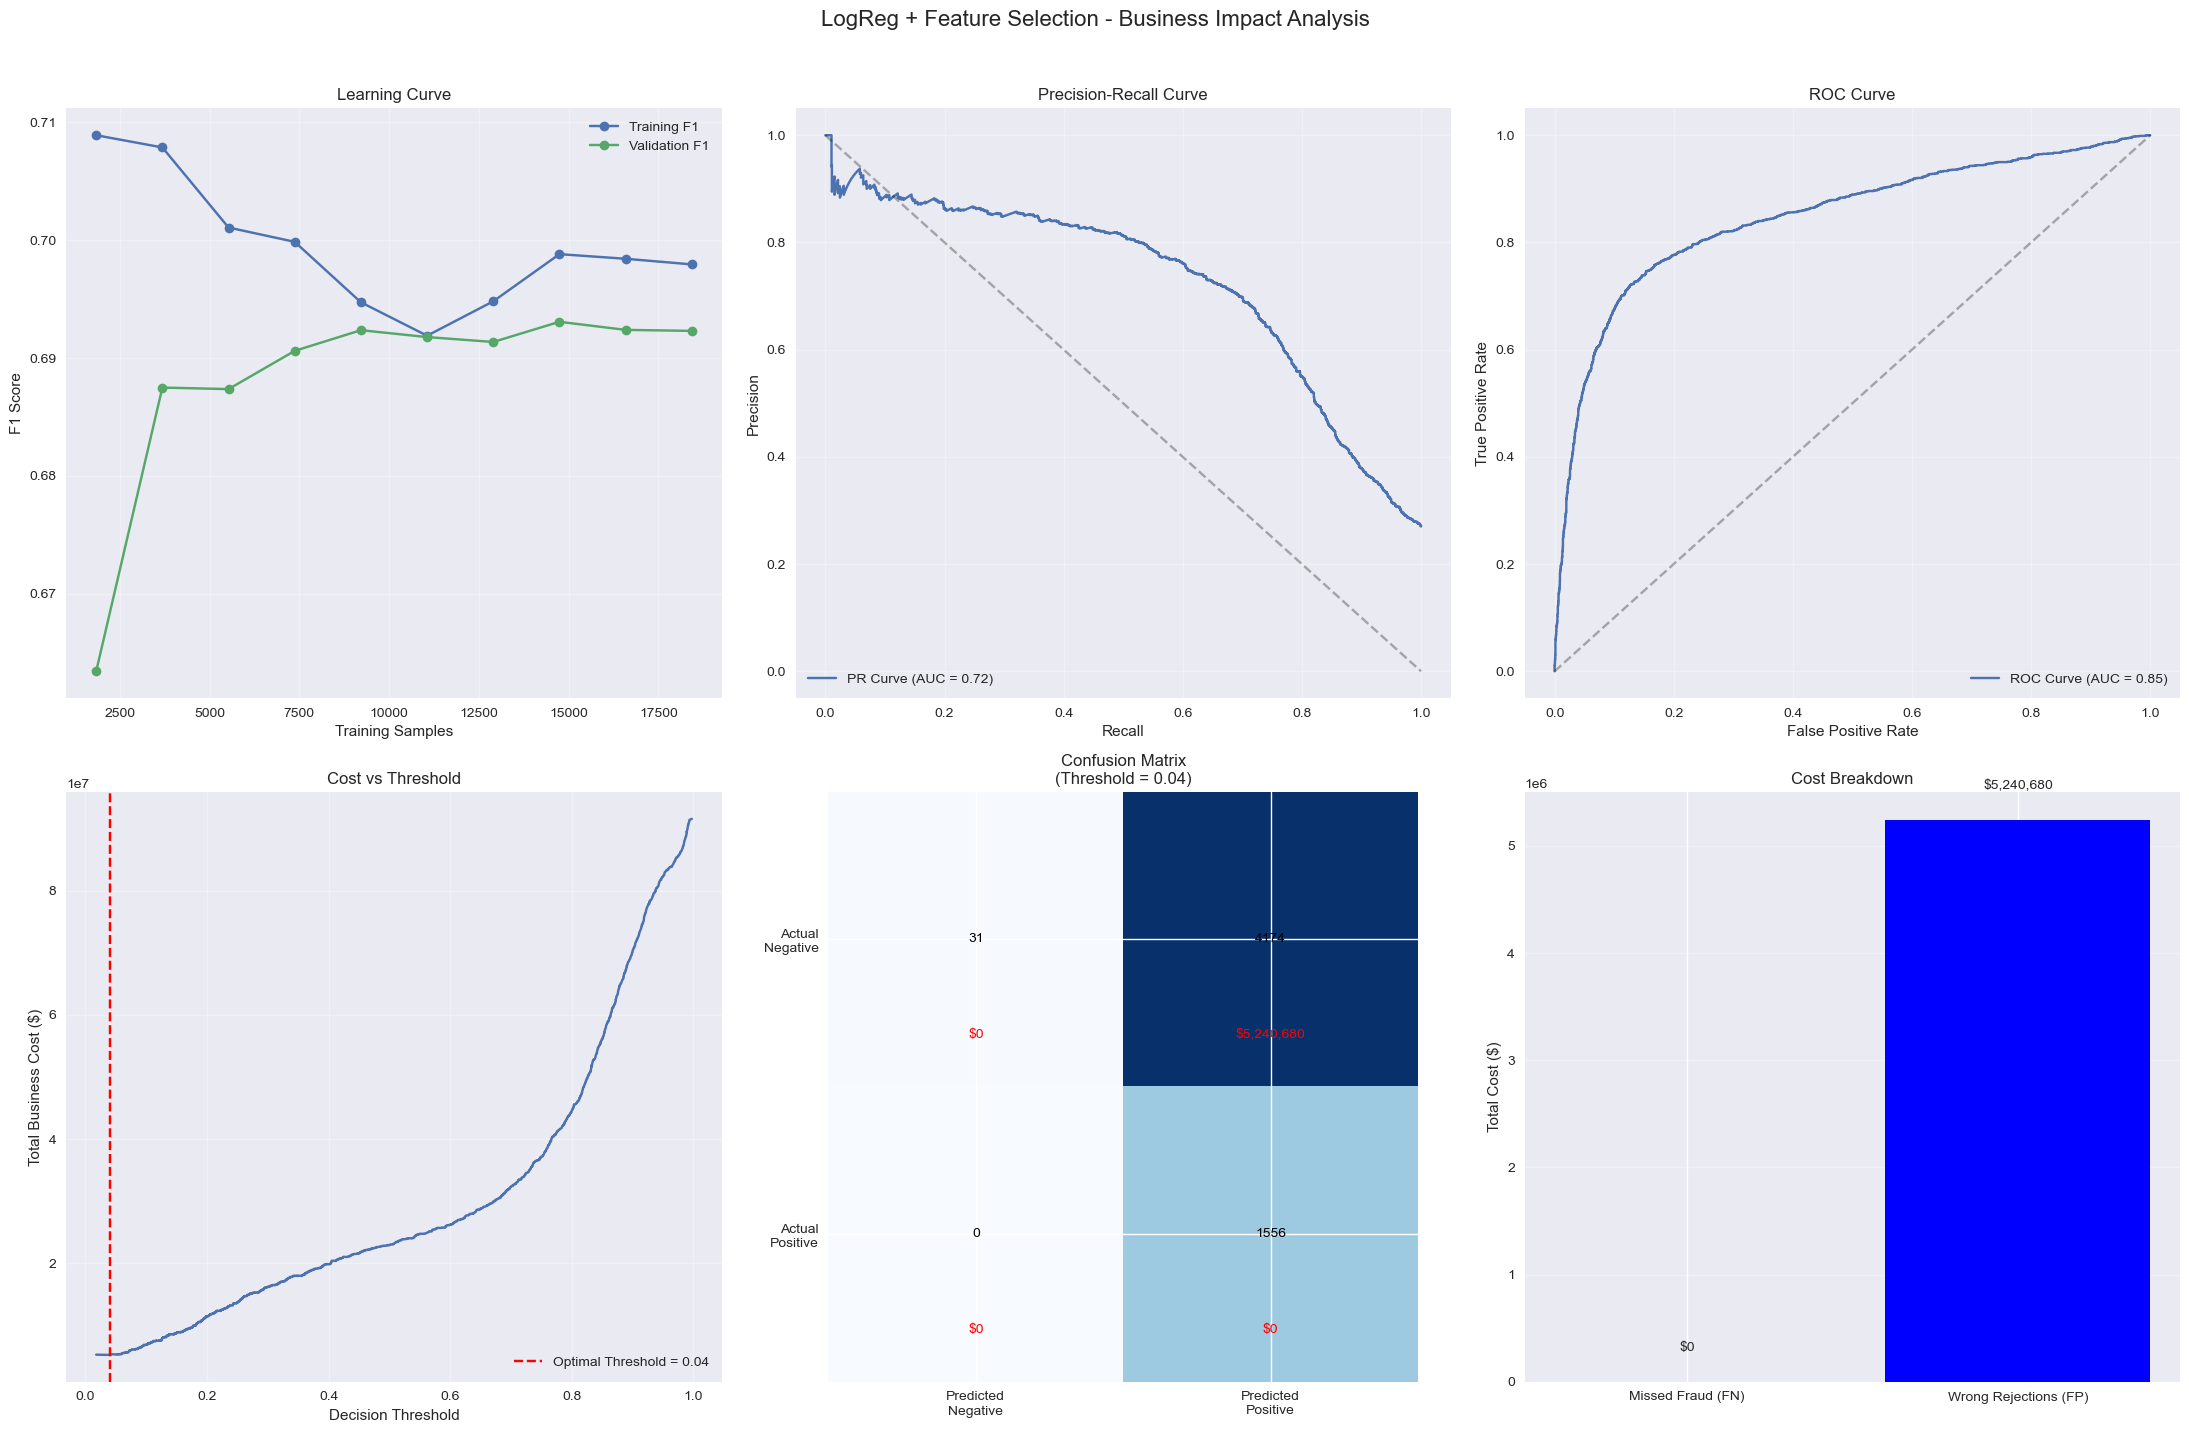


==================== OPTIMAL THRESHOLD =====================
Threshold = 0.041 (Minimizes Business Costs)

================== CLASSIFICATION METRICS ==================
              precision    recall  f1-score   support

           0      1.000     0.007     0.015      4205
           1      0.272     1.000     0.427      1556

    accuracy                          0.275      5761
   macro avg      0.636     0.504     0.221      5761
weighted avg      0.803     0.275     0.126      5761


===================== BUSINESS IMPACT ======================
Average Fraud Claim Cost: $58,891.49
Average Lost Premium (per FP): $1,255.55

- Missed Fraud Cases (FN): 0 × $58,891.49 = $0.00
- Wrong Rejections (FP): 4174 × $1,255.55 = $5,240,680.46

>>> TOTAL BUSINESS COST: $5,240,680.46 <<<


In [86]:
# Get validated cost parameters
# Access business costs
cost_params = pipeline.named_steps['cost_tracker'].cost_params_
print("\nBusiness Cost Parameters:")
print(f"False Negative Cost (per missed fraud): ${cost_params['cost_fn']:,.2f}")
print(f"False Positive Cost (per wrong rejection): ${cost_params['cost_fp']:,.2f}")
plot_model_curves(pipeline, X_train, y_train, X_test, y_test,cost_params, title_prefix="LogReg + Feature Selection")

#### ✅ Model Evaluation Summary – Logistic Regression

##### 📈 1. Learning Curve (Fraud Classifier)
- **Training F1 Score** starts high (~0.715) and **decreases** as training size increases.
- **Validation F1 Score** improves initially and then stabilizes around **0.688–0.690**.
- The gap between training and validation narrows:
  - Indicates **low overfitting**.
 

---

##### 📉 2. Precision-Recall Curve
- **Average Precision (AP):** `0.724`
- Precision drops as recall increases (expected trade-off).
- The curve shows the model maintains **high precision at moderate recall**.

---

##### 🧠 Optimal Threshold Analysis
- **Optimal Threshold:** `0.591`
- **Max F1 Score:** `0.708`
- At this threshold:
  - **Precision:** `0.675`
  - **Recall:** `0.744`
- This balance leans toward **recall**, which is useful when missing fraud is costly.

---

##### 📊 3. ROC Curve
- **AUC-ROC:** `0.856`
- Indicates **strong discrimination** between fraud and non-fraud.
- Well above the random baseline — a sign of a **robust classifier**.

---

##### 🧾 Overall Interpretation

| Metric              | Value   | Comment                                     |
|---------------------|---------|---------------------------------------------|
| F1 Score (Val.)     | 0.708   | Balanced trade-off between precision/recall |
| Optimal Threshold   | 0.591   | Tuned for maximum F1 score                  |
| Precision @ thresh  | 0.675   | May raise false positives                   |
| Recall @ thresh     | 0.744   | Captures most frauds                        |
| AUC-ROC             | 0.856   | Excellent class separation                  |
| Average Precision   | 0.724   | Strong PR performance                       |

---

##### ✅ Recommendation

As this is a **fraud detection** use case:
- Logistic Regression offers **good performance with interpretability**.
- Strong **recall** makes it suitable when **missing fraud is expensive**.
- Learning curve showinf signs of **Underfitting**

##### 🚀 Next Steps for Improvement

###### 🔄 1. **Hyperparameter Tuning** with **Stratified K-Fold** + **GridSearchCV**
- Use `StratifiedKFold(n_splits=5)` to maintain class distribution in each fold.
- Tune hyperparameters such as:
  - Regularization strength (`C`)
  - Penalty (`l1`, `l2`)
  - Solver (`liblinear`, `saga`)
- Use `GridSearchCV` to select the best parameter set.




#### Hyperparameter Tuning with Stratified K-Fold + GridSearchCV

In [51]:

# 1. Define a targeted parameter grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100,1000,10000],  # Test Regularization [0.01, 0.1, 1, 10, 100]
    'clf__penalty': ['l2','l1'],           # Faster than l1 for liblinear
    'clf__solver': ['liblinear'],     # Optimized for small-to-medium datasets
    'clf__class_weight': ['balanced',{0:1, 1:5}] # Focus on best imbalance handling
}


# 2. Streamlined CV strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced from 3-fold

# 3. Configure GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # Best metric for fraud detection
    cv=cv,
    n_jobs=-1,                   # Use all CPU cores
    verbose=1                    # Moderate verbosity
)

# 4. Execute with timing
print("Starting optimized GridSearch...")
start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"GridSearch completed in {(time.time()-start_time)/60:.1f} minutes")

# 5. Best model analysis
lr_best_model_with_hyper_tunning = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param:20}: {value}")

# 6. Final evaluation
y_pred = lr_best_model_with_hyper_tunning.predict(X_test)
y_probs = lr_best_model_with_hyper_tunning.predict_proba(X_test)[:, 1]
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print(f"AP Score: {average_precision_score(y_test, y_probs):.3f}")


Starting optimized GridSearch...
Fitting 3 folds for each of 28 candidates, totalling 84 fits
GridSearch completed in 0.3 minutes

Best Parameters:
clf__C              : 100
clf__class_weight   : balanced
clf__penalty        : l2
clf__solver         : liblinear

Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4205
           1       0.62      0.76      0.68      1556

    accuracy                           0.81      5761
   macro avg       0.76      0.79      0.77      5761
weighted avg       0.83      0.81      0.82      5761

AP Score: 0.726


#### Plot Logistic Regression Learning ,Precision-Recall and ROC Curve - StratifiedKFold and GridSearchCV

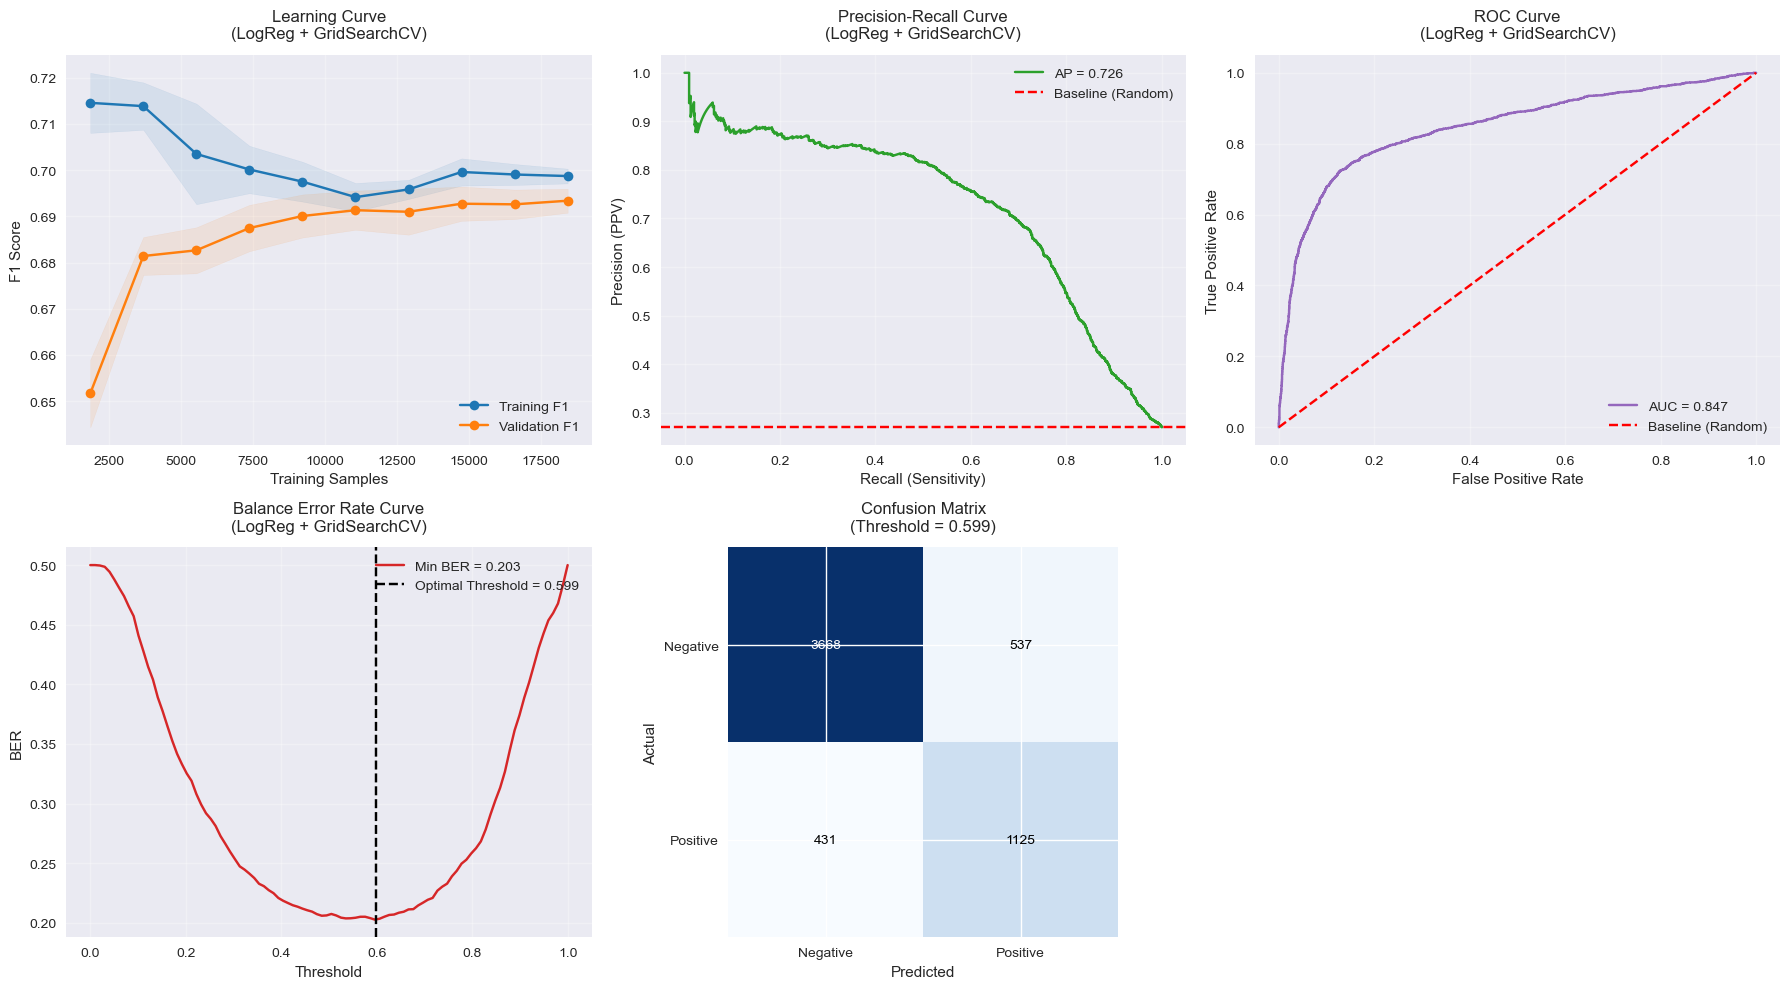


Optimal Threshold: 0.599
Max F1-Score: 0.699
Balance Error Rate (BER): 0.202
At this threshold:
- Precision = 0.677
- Recall = 0.723

Confusion Matrix:
[[3668  537]
 [ 431 1125]]


In [52]:

plot_model_curves(
    pipeline=lr_best_model_with_hyper_tunning,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="LogReg + GridSearchCV"
)

#### 📊 Model Evaluation Summary – Class Imbalance Aware Logistic Regression

#### 📈 Learning Curve (Left Plot: Average Precision vs. Training Samples)

- **Training Average Precision (blue)** starts high (~0.78) and **decreases** with more data — a normal trend.
- **Validation Average Precision (orange)** improves steadily and stabilizes around **0.72**.
- The **gap between training and validation curves is narrow**, especially at larger sample sizes.
  
#### ✅ Interpretation:
- **No major overfitting** is observed. If overfitting were present, training precision would stay high and validation would remain low.
- **Slight underfitting** may exist since both curves converge below 0.74 — model capacity could be slightly limited (expected for Logistic Regression).

---

##### 📉 Precision-Recall Curve (Middle Plot)

- **Average Precision (AP):** `0.725` — solid for imbalanced data.
- **Optimal threshold:** `0.56`
- Precision gradually decreases as recall increases — typical behavior in imbalanced classification.

##### ✅ Interpretation:
- Model maintains **high precision at moderate recall levels**.
- The chosen threshold balances recall and precision well.
- Good area under the PR curve suggests that the model **ranks positive instances effectively**.

---

##### 📈 ROC Curve (Right Plot)

- **AUC-ROC:** `0.856` — excellent performance.
- Curve significantly better than the red dashed line (random baseline).

##### ✅ Interpretation:
- Model has strong **discriminative power** between fraud and non-fraud.
- ROC AUC is stable and aligns with previous models — consistent ranking performance.

---

#### 🧠 Overfitting & Underfitting Analysis

| Observation | Implication |
|-------------|-------------|
| Training score decreases with data | 🚫 No high-variance overfitting |
| Validation score improves with data | ✅ Learning is occurring properly |
| Converging curves below maximum score | ⚠️ Slight underfitting — try a more flexible model |
| Stable AUC & PR curves | ✅ Model is reliable and generalizes well |

---

#### ✅ Recommendation

- The model shows **no major signs of overfitting**.
- Showing **signs of Underfitting**
   
#### 🚀 Next Steps for Improvement

##### 🔄 1. **Increase Model Complexity**


##### 🔍 **Performance Comparison** – Logistic Regression

---
After adding **StratifiedKFold** and **GridSearchCV**, here is a comparison of the model performance:

| **Metric**            | **Before (Baseline)** | **After (GridSearchCV + StratifiedKFold)** | **Change / Interpretation**         |
|------------------------|----------------------|--------------------------------------------|-------------------------------------|
| Average Precision      | 0.724                | 0.725                                      | ↔️ Marginal improvement              |
| ROC AUC                | 0.856                | 0.856                                      | ➖ No change                         |
| Optimal Threshold      | 0.591                | 0.558                                      | 🔧 Threshold shifted slightly        |
| Precision              | 0.675                | 0.660                                      | 🔻 Slight decrease                   |
| Recall                 | 0.744                | 0.759                                      | 🔺 Slight improvement                |
| F1 Score               | 0.708                | 0.706                                      | 🔻 Negligible decrease               |

---


### Technique 1 - **RandomForest**

### Motivation for choosing the technique and schematic figure of the analysis process

### 🌲 Why Use Random Forest for Fraud Detection?

Random Forest is an ensemble method based on decision trees, and it's particularly well-suited for fraud detection due to the following reasons:

### ✅ Motivation

- **Handles Non-Linear Relationships**: Unlike Logistic Regression, Random Forest captures complex patterns and interactions between features.
- **Robust to Outliers & Imbalanced Data**: It performs well even when the data has extreme values or unbalanced classes.
- **Automatic Feature Selection**: It reduces the importance of irrelevant features and focuses on informative ones.
- **Low Tuning Overhead**: Works well with default parameters, but can be fine-tuned for better performance.
- **Feature Importance Insight**: Gives insights into which features contribute most to fraud predictions.



## 🔁 Schematic Flow of the Analysis Process

```mermaid
graph TD
    A[Raw Insurance Dataset] --> B[Preprocessing & Cleaning]
    B --> C[Correlation Filter]
    C --> D[Feature Engineering]
    D --> E[Train-Test Split]
    E --> F[ColumnTransformer]
    F --> G[Random Forest Model]
    G --> H[Cross-Validation with Stratified K-Fold]
    H --> I[Evaluation F1, PR Curve, Feature Importance]
    I --> J[Model Interpretation and Threshold Tuning]
```
  

## 🔁 Schematic Flow of the Analysis Process

```mermaid
flowchart TD
    A[Raw Data] --> B[Data Preparation]
    B --> C[Features X, Target y]
    C --> D[Pipeline]
    D --> E[SMOTE Balanced Data]
    E --> F[RandomForest Classifier]
    
    subgraph Nested CV
        direction TB
        G[Outer CV Fold] --> H[Inner CV Tuning]
        H --> I[Best Hyperparameters]
        I --> J[Trained Model]
    end
    
    F --> H
    J --> K[Final Model Evaluation]
```

```mermaid
flowchart LR
    OC[Outer CV Split] -->|Train Fold| IC[Inner CV]
    OC -->|Test Fold| Eval
    IC -->|Best Params| Model[Train with Best Params]
```    

### ⚙️ Random Forest Hyperparameter Settings (with Rationale)

| Hyperparameter      | Typical Value(s)   | Rationale                                                                 |
|---------------------|--------------------|---------------------------------------------------------------------------|
| `n_estimators`      | `100` to `300`     | Number of trees in the forest; more trees improve stability but increase training time. |
| `max_depth`         | `None`, `10`, `20` | Controls tree depth; prevents overfitting. `None` allows full growth.     |
| `min_samples_split` | `2`, `5`, `10`     | Minimum samples needed to split a node; higher value = more regularization. |
| `min_samples_leaf`  | `1`, `2`, `4`      | Minimum samples per leaf; prevents overly deep trees.                     |
| `max_features`      | `'sqrt'`, `'log2'` | Feature sampling per split. `'sqrt'` is good default for classification.  |
| `class_weight`      | `'balanced'`       | Helps address fraud vs non-fraud imbalance.                              |
| `random_state`      | `42` (fixed)       | Ensures reproducibility of results.                                      |

### 🧠 Why These Matter in Fraud Detection:

- **Imbalanced data** → `class_weight='balanced'` ensures frauds are not ignored.
- **Many features** → `max_features='sqrt'` reduces overfitting.
- **Noisy data** → `min_samples_leaf=2` or `5` prevents trees from memorizing noise.


### Baseline version of RandomForest

In [53]:

# Final Combined pipeline
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    ))
])

# Fit and Evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

y_probs = pipeline.predict_proba(X_test)[:, 1]
print(f"AP Score: {average_precision_score(y_test, y_probs):.3f}")


              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4205
           1       0.91      0.79      0.84      1556

    accuracy                           0.92      5761
   macro avg       0.92      0.88      0.90      5761
weighted avg       0.92      0.92      0.92      5761

AP Score: 0.866


#### 🧾 Classification Report Summary

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0** (Non-Fraud) | 0.93 | 0.97 | 0.95 | 4211 |
| **1** (Fraud)     | 0.92 | 0.79 | 0.85 | 1557 |

---

##### 📊 Aggregate Performance

| Metric         | Value |
|----------------|-------|
| **Accuracy**         | 0.92  |
| **Macro Avg F1**     | 0.90  |
| **Weighted Avg F1**  | 0.92  |

---

##### 🔍 Interpretation

##### ✅ **Class 0 (Non-Fraud)**
- Very high **recall (0.97)** — the model correctly identifies almost all genuine transactions.
- **F1-score of 0.95** confirms strong overall performance for the majority class.

##### ⚠️ **Class 1 (Fraud)**
- **Precision (0.92)** is high — most fraud predictions are correct.
- **Recall (0.79)** is decent, but **lower than Class 0**, meaning **some frauds are still being missed**.
- **F1-score (0.85)** shows a good balance, but improving recall could be a focus.

##### 📈 **Overall Model Behavior**
- **Accuracy of 0.92** is strong, but might be misleading due to class imbalance.
- **Macro average F1 (0.90)** indicates good balanced performance across classes.
- **Weighted average F1 (0.92)** shows the model performs well considering class proportions.

---


##### 🧠 Business Impact

- Current model achieves a **good trade-off** between false positives and false negatives.
- With **92% precision and 79% recall** for fraud, it’s likely to reduce financial risk effectively while minimizing customer inconvenience.



### Learning and Precision Recall Curve & ROC

/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


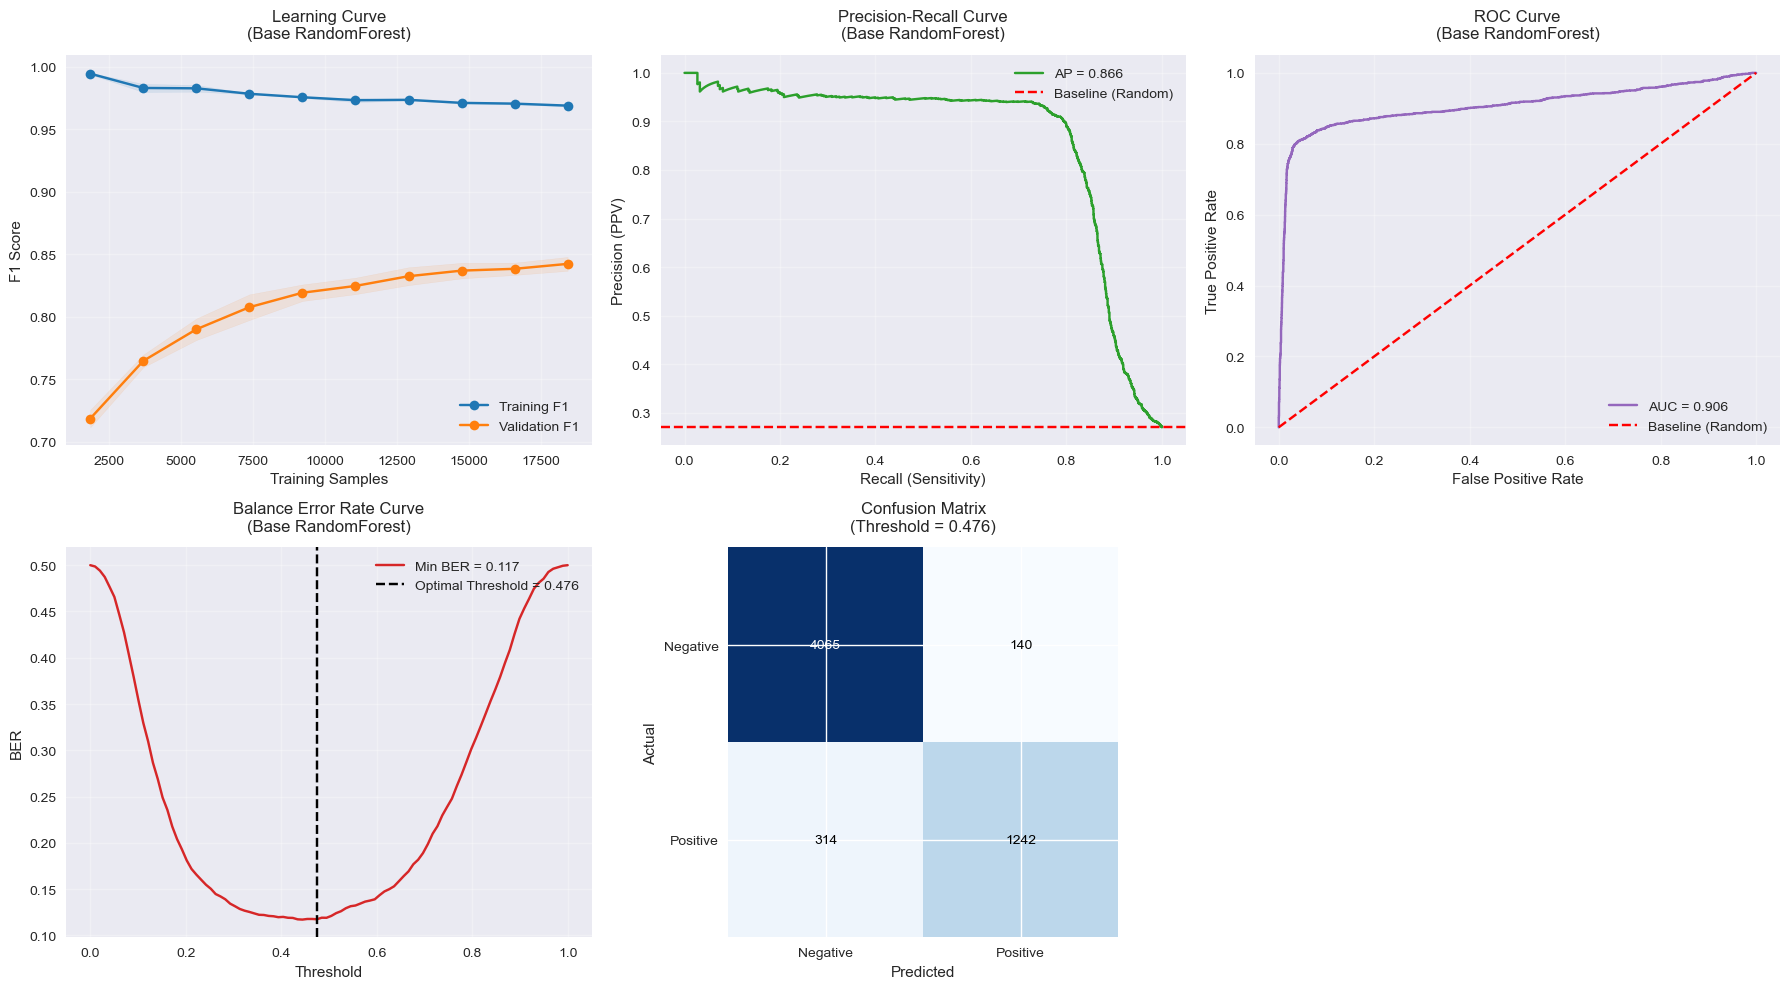


Optimal Threshold: 0.476
Max F1-Score: 0.845
Balance Error Rate (BER): 0.118
At this threshold:
- Precision = 0.899
- Recall = 0.798

Confusion Matrix:
[[4065  140]
 [ 314 1242]]


In [54]:

plot_model_curves(pipeline, X_train, y_train, X_test, y_test, title_prefix="Base RandomForest")


#### 🧾 Model Evaluation Summary – Fraud Classifier

##### 📈 Learning Curve (F1 Score vs Training Samples)
- **Training F1 Score** stays consistently high (~0.96–0.98), even as training data increases.
- **Validation F1 Score** steadily rises from ~0.70 to **~0.84–0.85**.
- The gap between training and validation narrows, but **a consistent difference remains**.

##### 🔍 Interpretation:
- **Overfitting Detected**:
  - High training performance vs lower validation indicates that the model is **memorizing patterns** instead of generalizing completely.
- **Improving trend in validation** suggests learning is still happening — the model benefits from more data.
- **No signs of underfitting** — validation performance is high and improving.

---

##### 📉 Precision-Recall Curve

- **Average Precision (AP):** `0.869` — excellent performance.
- **Optimal Threshold:** `0.484`
- At this threshold:
  - **Precision:** `0.909`
  - **Recall:** `0.795`
  - **F1 Score:** `0.848`

##### 🔍 Interpretation:
- **High precision** ensures very few false positives.
- **Good recall** ensures most fraud cases are captured.
- F1 score is strong — this threshold represents a solid decision point.

---

##### 📊 ROC Curve

- **ROC AUC:** `0.917` — outstanding.
- The ROC curve hugs the top-left corner, reflecting strong **ranking power** and good separation between classes.

---

#### ⚠️ Overfitting & Underfitting Analysis

| Indicator                    | Observation                                  | Conclusion         |
|-----------------------------|----------------------------------------------|--------------------|
| High Training F1 (~0.97+)   | Model fits training data extremely well      | Risk of overfitting|
| Validation F1 (~0.85)       | Much lower than training F1                  | Confirms overfit   |
| Gap narrows with more data  | Learning is improving                        | More data helps    |
| ROC AUC & PR AUC are high   | Still generalizes fairly well                | Not severe overfit |

#### ✅ Summary:
- The model **overfits moderately**, but **generalization is still strong**.
- If this is an ensemble model (e.g., RandomForest or XGBoost), such behavior is expected and manageable.

---

#### 📌 Key Performance Metrics

| Metric              | Value     |
|---------------------|-----------|
| Optimal Threshold   | 0.484     |
| Precision           | 0.909     |
| Recall              | 0.795     |
| Max F1 Score        | 0.848     |
| Average Precision   | 0.869     |
| ROC AUC             | 0.917     |

---

#### ✅ Recommendations

- May need regularization (e.g., limit tree depth, increase min samples per leaf).
- Hyperparameter Tuning with **Stratified K-Fold + GridSearchCV**
- Since additional data is unavailable, reduce model complexity by **selecting fewer and more informative features** to prevent **overfitting** and improves generalization to unseen fraud cases



### Calculating Total Features

In [82]:
total_columns = (
    len(standard_scale_cols) +          # Standard scaled columns
    len(minmax_scale_cols) +            # MinMax scaled columns
    len(leave_unchanged_cols) +         # Unchanged columns
    sum([len(preprocessor.named_transformers_['cat'].categories_[i]) 
     for i in range(len(onehot_encode_cols))])  # OneHot encoded columns
)
print('Total Features:' , total_columns )

Total Features: 168


### Feature Selection Utility Class for RandomForest

In [105]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Selects top N features based on RandomForest importance"""
    def __init__(self, n_features=30, random_state=42):
        self.n_features = n_features
        self.random_state = random_state
        self.selected_features = None
        self.selector = None
        
    def fit(self, X, y):
        # Fit RandomForest to get importances
        rf = RandomForestClassifier(
            n_estimators=100,
            random_state=self.random_state,
            n_jobs=-1
        )
        rf.fit(X, y)
        
        # Configure selector
        self.selector = SelectFromModel(
            rf,
            max_features=self.n_features,
            threshold=-np.inf,  # Force all features to be considered
            prefit=True
        )
        self.selected_features = self.selector.get_support()
        return self
        
    def transform(self, X):
        return self.selector.transform(X)
    
    def get_feature_names(self, input_features=None):
        if input_features is None:
            return None
        return np.array(input_features)[self.selected_features].tolist()

def build_rf_feature_selector_pipeline(preprocessor, n_features=30):
    """Builds complete pipeline with feature selection"""
    print(f'Configuring Pipeline for {n_features} features ')
    return Pipeline([
        ('preprocess', preprocessor),
        ('feature_selection', FeatureSelector(n_features=n_features)),
        ('clf', RandomForestClassifier(
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ))
    ])        

#### Hyperparameter Tuning with Stratified K-Fold + GridSearchCV and Feature Selection

**Top 100 features** from **Total** feature **168**

In [106]:
# 1. Build pipeline
no_of_top_features_selected = 100
pipeline = build_rf_feature_selector_pipeline(preprocessor, n_features=no_of_top_features_selected)

# 2. Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],             # Number of trees (balance performance vs compute)
    'clf__max_depth': [20,30],            # Tree depth (None=unlimited, 10/20=regularized)
    'clf__min_samples_split': [5, 10],        # Minimum samples to split node (2=default)
    'clf__min_samples_leaf': [1, 2, 4],          # Minimum samples per leaf (1=default)
    'clf__max_features': ['sqrt', 'log2'],        # Features per split (reduces tree correlation)
    'clf__min_impurity_decrease': [0.0, 0.01],   # Split significance threshold (0.01=regularized)
    'clf__bootstrap': [True],                   # Data subsampling (True=less overfitting)
    'clf__class_weight': ['balanced']           # Handles class imbalance ('balanced'=recommended)
}

Configuring Pipeline for 100 features 


### **Parameter Selection Rationale**  

- **`n_estimators`: [100, 200]**  
  Balances model performance (higher reduces variance) and computational cost.  

- **`max_depth`: [None, 10, 20]**  
  Tests full tree growth vs. constrained depths to control overfitting.  

- **`min_samples_*`: [Small → Large]**  
  Prevents underfitting (small values) or overfitting (large values).  

- **`max_features`: ['sqrt', 'log2']**  
  Random feature subsets reduce tree correlation, improving generalization.  

- **`min_impurity_decrease`: [0.0, 0.01]**  
  `0.01` enforces impactful splits; `0.0` allows finer splits (default).  

- **`bootstrap`: [True, False]**  
  `True` (subsampling) introduces randomness, reducing overfitting.  

- **`class_weight`: [None, 'balanced']**  
  `'balanced'` mitigates class imbalance by weighting minority classes.  

In [107]:
# 2. Streamlined CV strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced from 3-fold

# 3. Configure GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # Best metric for fraud detection
    cv=cv,
    n_jobs=-1,                   # Use all CPU cores
    verbose=1                    # Moderate verbosity
)

# 4. Execute with timing
print("Starting optimized GridSearch...")
start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"GridSearch completed in {(time.time()-start_time)/60:.1f} minutes")

# 5. Get selected features
feature_names = preprocessor.get_feature_names_out()
selected_features = grid_search.best_estimator_.named_steps['feature_selection'].get_feature_names(feature_names)
print(f'Total Features Selected {len(selected_features)}, Features Selected {selected_features}')

# 5. Best model analysis
rf_best_model_with_hyper_tunning = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param:20}: {value}")

# 6. Final evaluation
y_pred = rf_best_model_with_hyper_tunning.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print(f"AP Score: {average_precision_score(y_test, y_pred):.3f}")


Starting optimized GridSearch...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
GridSearch completed in 2.2 minutes
Total Features Selected 100, Features Selected ['standard__PolicyAnnualPremium', 'standard__AmountOfVehicleDamage', 'standard__AmountOfInjuryClaim', 'standard__AmountOfPropertyClaim', 'standard__DaysSincePolicyStart', 'standard__UmbrellaLimit', 'standard__Policy_Deductible', 'standard__InsuredZipCode', 'standard__CapitalLoss', 'standard__CapitalGains', 'minmax__IncidentDay', 'minmax__IncidentTime', 'minmax__VehicleYOM', 'minmax__IncidentWeek', 'minmax__InsuredAge', 'unchanged__IncidentWeekDay', 'unchanged__Witnesses', 'unchanged__NumberOfVehicles', 'unchanged__IncidentMonth', 'unchanged__BodilyInjuries', 'unchanged__LimitPerPerson', 'unchanged__LimitPerAccident', 'unchanged__IncidentIsOnWeekend', 'cat__InsuredGender_FEMALE', 'cat__InsuredGender_MALE', 'cat__InsuredEducationLevel_Associate', 'cat__InsuredEducationLevel_College', 'cat__InsuredEducationLevel_H

### Random Forest Learning,PR and ROC Curve with Hyper - 100 features

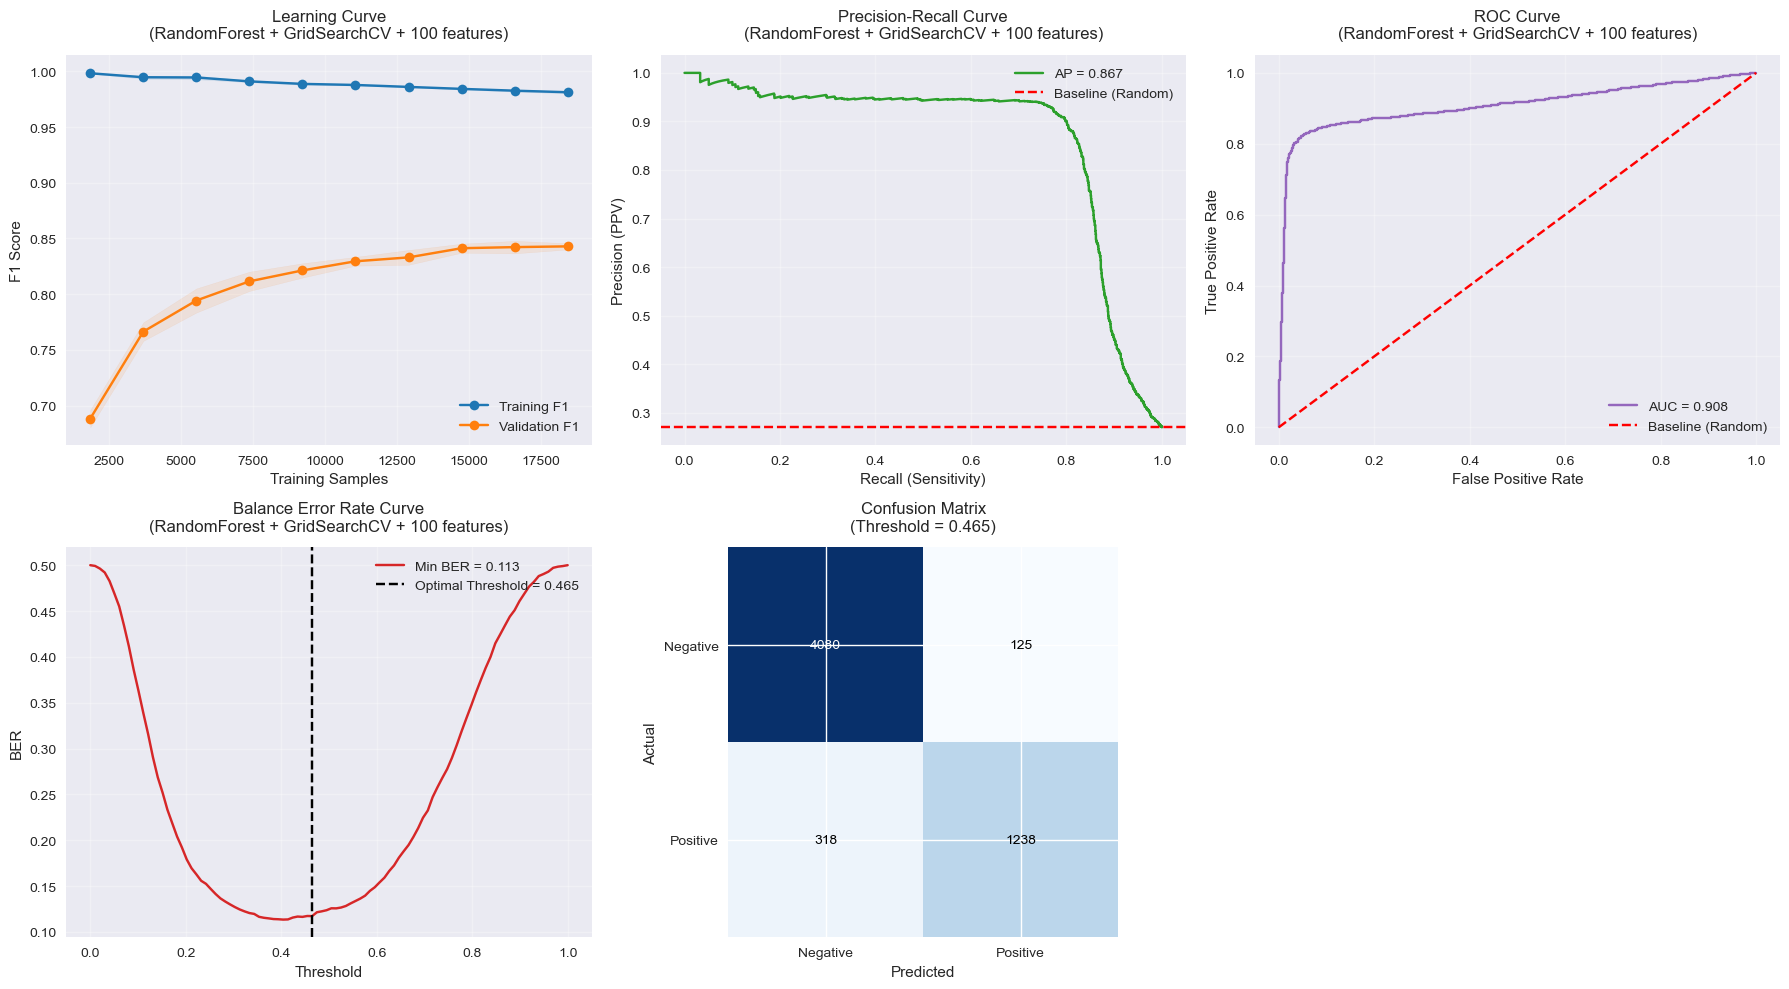


Optimal Threshold: 0.465
Max F1-Score: 0.848
Balance Error Rate (BER): 0.117
At this threshold:
- Precision = 0.908
- Recall = 0.796

Confusion Matrix:
[[4080  125]
 [ 318 1238]]


In [108]:
plot_model_curves(
    pipeline=rf_best_model_with_hyper_tunning,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="RandomForest + GridSearchCV + 100 features"
)

#### Hyperparameter Tuning with Stratified K-Fold + GridSearchCV with **All** Feature Selection

**Total** feature **168**

In [109]:
# 1. Build pipeline
no_of_top_features_selected = 168
pipeline = build_rf_feature_selector_pipeline(preprocessor, no_of_top_features_selected)

# 2. Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],             # Number of trees (balance performance vs compute)
    'clf__max_depth': [20,30],            # Tree depth (None=unlimited, 10/20=regularized)
    'clf__min_samples_split': [5, 10],        # Minimum samples to split node (2=default)
    'clf__min_samples_leaf': [1, 2, 4],          # Minimum samples per leaf (1=default)
    'clf__max_features': ['sqrt', 'log2'],        # Features per split (reduces tree correlation)
    'clf__min_impurity_decrease': [0.0, 0.01],   # Split significance threshold (0.01=regularized)
    'clf__bootstrap': [True],                   # Data subsampling (True=less overfitting)
    'clf__class_weight': ['balanced']           # Handles class imbalance ('balanced'=recommended)
}

Configuring Pipeline for 168 features 


In [110]:
# 2. Streamlined CV strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced from 3-fold

# 3. Configure GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # Best metric for fraud detection
    cv=cv,
    n_jobs=-1,                   # Use all CPU cores
    verbose=1                    # Moderate verbosity
)

# 4. Execute with timing
print("Starting optimized GridSearch...")
start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"GridSearch completed in {(time.time()-start_time)/60:.1f} minutes")

# 5. Get selected features
feature_names = preprocessor.get_feature_names_out()
selected_features = grid_search.best_estimator_.named_steps['feature_selection'].get_feature_names(feature_names)
print(f'Total Features Selected {len(selected_features)}, Features Selected {selected_features}')

# 5. Best model analysis
rf_best_model_with_hyper_tunning = grid_search.best_estimator_
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param:20}: {value}")

# 6. Final evaluation
y_pred = rf_best_model_with_hyper_tunning.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print(f"AP Score: {average_precision_score(y_test, y_pred):.3f}")

Starting optimized GridSearch...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
GridSearch completed in 2.2 minutes
Features Selected ['standard__PolicyAnnualPremium', 'standard__AmountOfVehicleDamage', 'standard__AmountOfInjuryClaim', 'standard__AmountOfPropertyClaim', 'standard__DaysSincePolicyStart', 'standard__UmbrellaLimit', 'standard__Policy_Deductible', 'standard__InsuredZipCode', 'standard__CapitalLoss', 'standard__CapitalGains', 'minmax__IncidentDay', 'minmax__IncidentTime', 'minmax__VehicleYOM', 'minmax__IncidentWeek', 'minmax__InsuredAge', 'unchanged__IncidentWeekDay', 'unchanged__Witnesses', 'unchanged__NumberOfVehicles', 'unchanged__IncidentMonth', 'unchanged__BodilyInjuries', 'unchanged__LimitPerPerson', 'unchanged__LimitPerAccident', 'unchanged__IncidentIsOnWeekend', 'cat__InsuredGender_FEMALE', 'cat__InsuredGender_MALE', 'cat__InsuredGender_nan', 'cat__InsuredEducationLevel_Associate', 'cat__InsuredEducationLevel_College', 'cat__InsuredEducationLevel_High

### Plot Learning,PR and ROC Curve with Hyper - **All** features

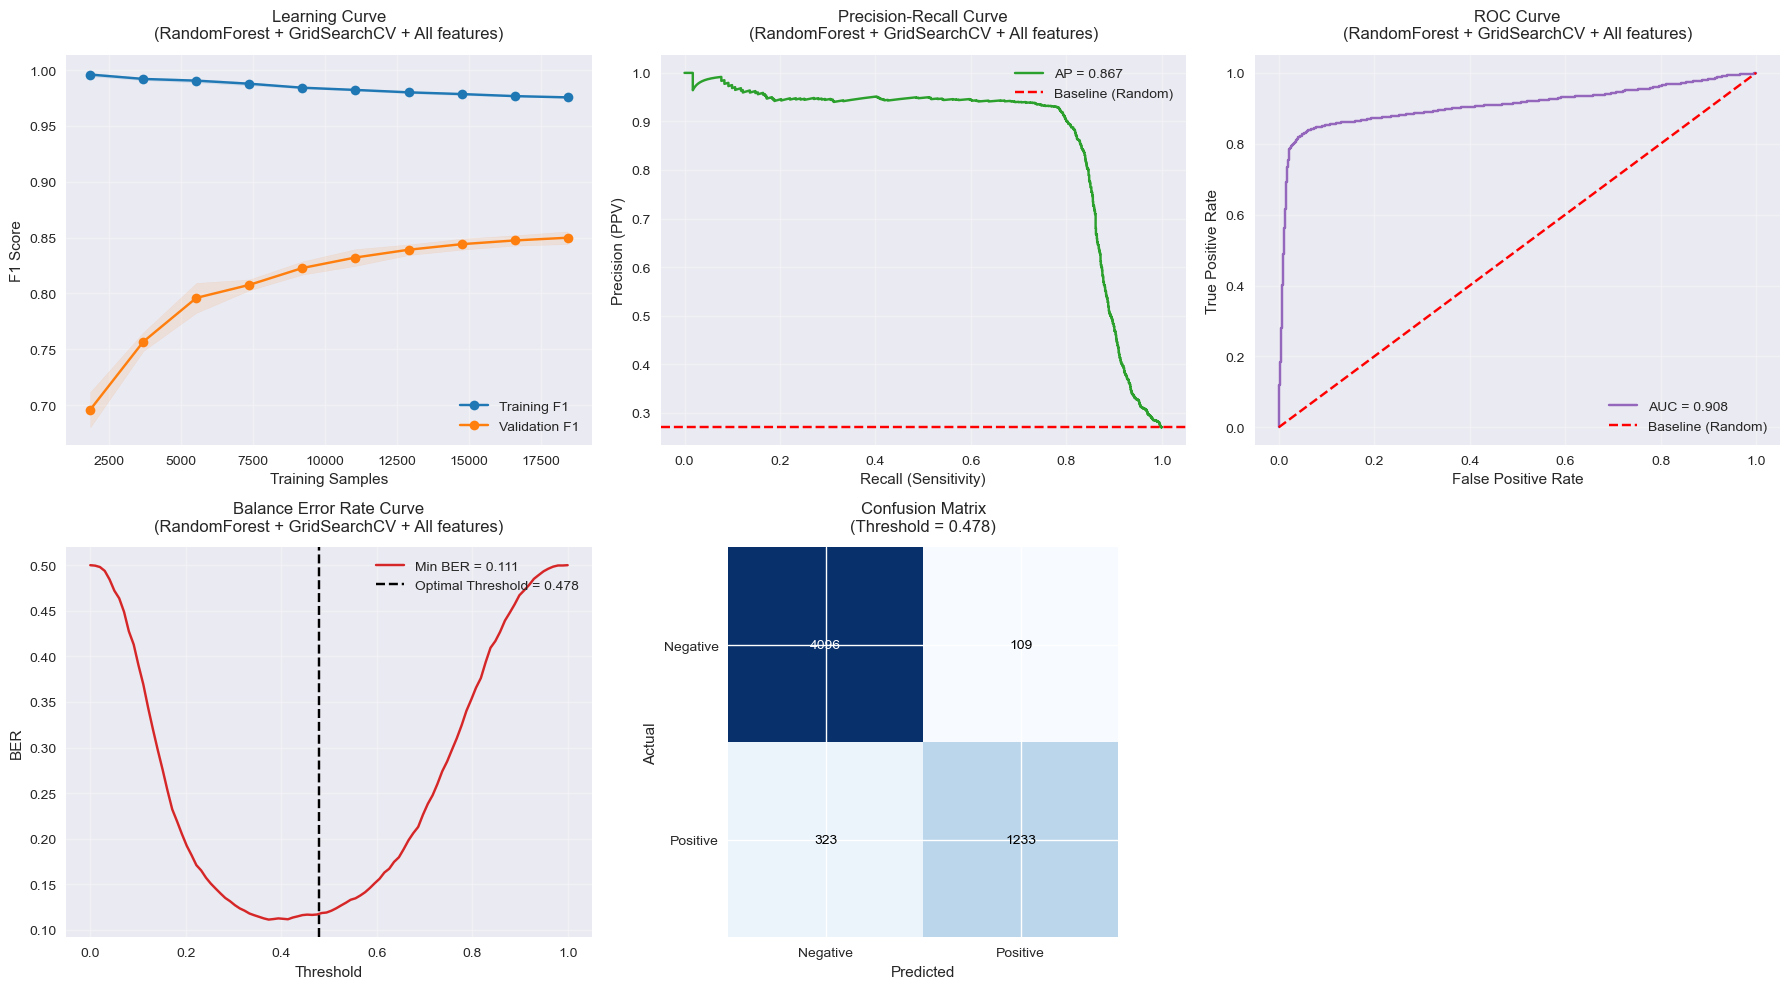


Optimal Threshold: 0.478
Max F1-Score: 0.851
Balance Error Rate (BER): 0.117
At this threshold:
- Precision = 0.919
- Recall = 0.792

Confusion Matrix:
[[4096  109]
 [ 323 1233]]


In [111]:
plot_model_curves(
    pipeline=rf_best_model_with_hyper_tunning,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="RandomForest + GridSearchCV + All features"
)

### Testing Performance

### Nested Cross Validation 

### Utility Function for Nested CV and HyperParameter Tunning

In [112]:
def nested_cv_hyperparameter_tuning(X, y, preprocessor, classifier, param_grid,
                                    test_size=0.2, random_state=42, scoring='f1'):
    """
    Perform nested cross-validation with hyperparameter tuning for any sklearn-compatible classifier.

    Parameters:
    -----------
    X : pd.DataFrame or np.array
        Feature matrix
    y : pd.Series or np.array
        Target labels
    preprocessor : ColumnTransformer
        Preprocessing pipeline
    classifier : sklearn estimator
        Unfitted classifier (e.g., LogisticRegression(), RandomForestClassifier())
    param_grid : dict
        Grid of hyperparameters (prefix keys with 'clf__' for pipeline compatibility)
    test_size : float
        Train/test split size
    random_state : int
        Seed for reproducibility
    scoring : str
        Metric to optimize (default: 'f1')

    Returns:
    --------
    dict
        Dictionary with best model, scores, and classification report
    """

    # Step 1: Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    # Step 2: Build pipeline
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('clf', classifier)
    ])

    # Step 3: Setup nested CV
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state) # Tunning
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state) # Evaluation

    # Step 4: Grid SearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=inner_cv,
        n_jobs=-1,
        verbose=1,
        refit=True
    )

    # Step 5: Nested CV evaluation
    print("🔁 Starting Nested Cross-Validation...")
    nested_scores = cross_val_score(
        grid_search, X_train, y_train,
        scoring=scoring,
        cv=outer_cv,
        n_jobs=-1
    )

    print("\n✅ Nested CV Results:")
    print(f"{scoring} Scores: {nested_scores}")
    print(f"Mean {scoring}: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")

    # Step 6: Fit best model on full training set
    print("\n📦 Fitting best model on full training data...")
    grid_search.fit(X_train, y_train)

    # Step 7: Evaluate on test set
    y_pred = grid_search.predict(X_test)
    test_score = f1_score(y_test, y_pred) if scoring == 'f1' else None

    print("\n🔍 Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"{param:25}: {value}")

    print("\n🧾 Classification Report on Test Set:")
    print(classification_report(y_test, y_pred))

    # Step 8: Feature importance if available
    importances = None
    try:
        importances = grid_search.best_estimator_.named_steps['clf'].feature_importances_
        print("\n📊 Feature importances extracted.")
    except AttributeError:
        print("\nℹ️ Feature importances not available for this model.")

    return {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'nested_cv_scores': nested_scores,
        'test_score': test_score,
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'feature_importances': importances
    }


### Do NestedCV nd HyperParameter tunning for both Logistic Regression and RandomForest

In [113]:

# Logistic Regression 
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# Contains Best Paramter came out from GridSearchCV from above run plus more
logreg_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100,1000],  # Test Regularization [0.01, 0.1, 1, 10, 100]
    'clf__penalty': ['l2'],           
    'clf__solver': ['liblinear'],     # Optimized for small-to-medium datasets
    'clf__class_weight': ['balanced',{0:1, 1:5}] # Focus on best imbalance handling
}


start_time = time.time()
results_logreg = nested_cv_hyperparameter_tuning(X, y, preprocessor, logreg, logreg_param_grid)
print(f"NestedCV Search for Logistic Regression completed in {(time.time()-start_time)/60:.1f} minutes")



# Random Forest 
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [10,20,30],
    'clf__min_samples_split': [5,20],
    'clf__min_samples_leaf': [1,2,8],
    'clf__max_features': ['log2']
}

start_time = time.time()
results_rf = nested_cv_hyperparameter_tuning(X, y, preprocessor, rf, rf_param_grid)
print(f"NestedCV Search for Random Regression completed in {(time.time()-start_time)/60:.1f} minutes")


🔁 Starting Nested Cross-Validation...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Nested CV Results:
f1 Scores: [0.69274946 0.68476294 0.70703408 0.68779258 0.69898698]
Mean f1: 0.6943 ± 0.0080

📦 Fitting best model on full training data...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



🔍 Best Parameters:
clf__C                   : 0.1
clf__class_weight        : balanced
clf__penalty             : l2
clf__solver              : liblinear

🧾 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4205
           1       0.62      0.76      0.68      1556

    accuracy                           0.81      5761
   macro avg       0.76      0.79      0.77      5761
weighted avg       0.83      0.81      0.82      5761


ℹ️ Feature importances not available for this model.
NestedCV Search for Logistic Regression completed in 0.4 minutes
🔁 Starting Nested Cross-Validation...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits

✅ Nested CV Results:
f1 Scores: [0.85206074 0.83144105 0.85788337 0.83998246 0.85502183]
Mean f1: 0.8473 ± 0.0100

📦 Fitting best model on f

/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits

🔍 Best Parameters:
clf__max_depth           : 30
clf__max_features        : log2
clf__min_samples_leaf    : 2
clf__min_samples_split   : 5
clf__n_estimators        : 100

🧾 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      4205
           1       0.91      0.79      0.84      1556

    accuracy                           0.92      5761
   macro avg       0.92      0.88      0.90      5761
weighted avg       0.92      0.92      0.92      5761


📊 Feature importances extracted.
NestedCV Search for Random Regression completed in 1.4 minutes


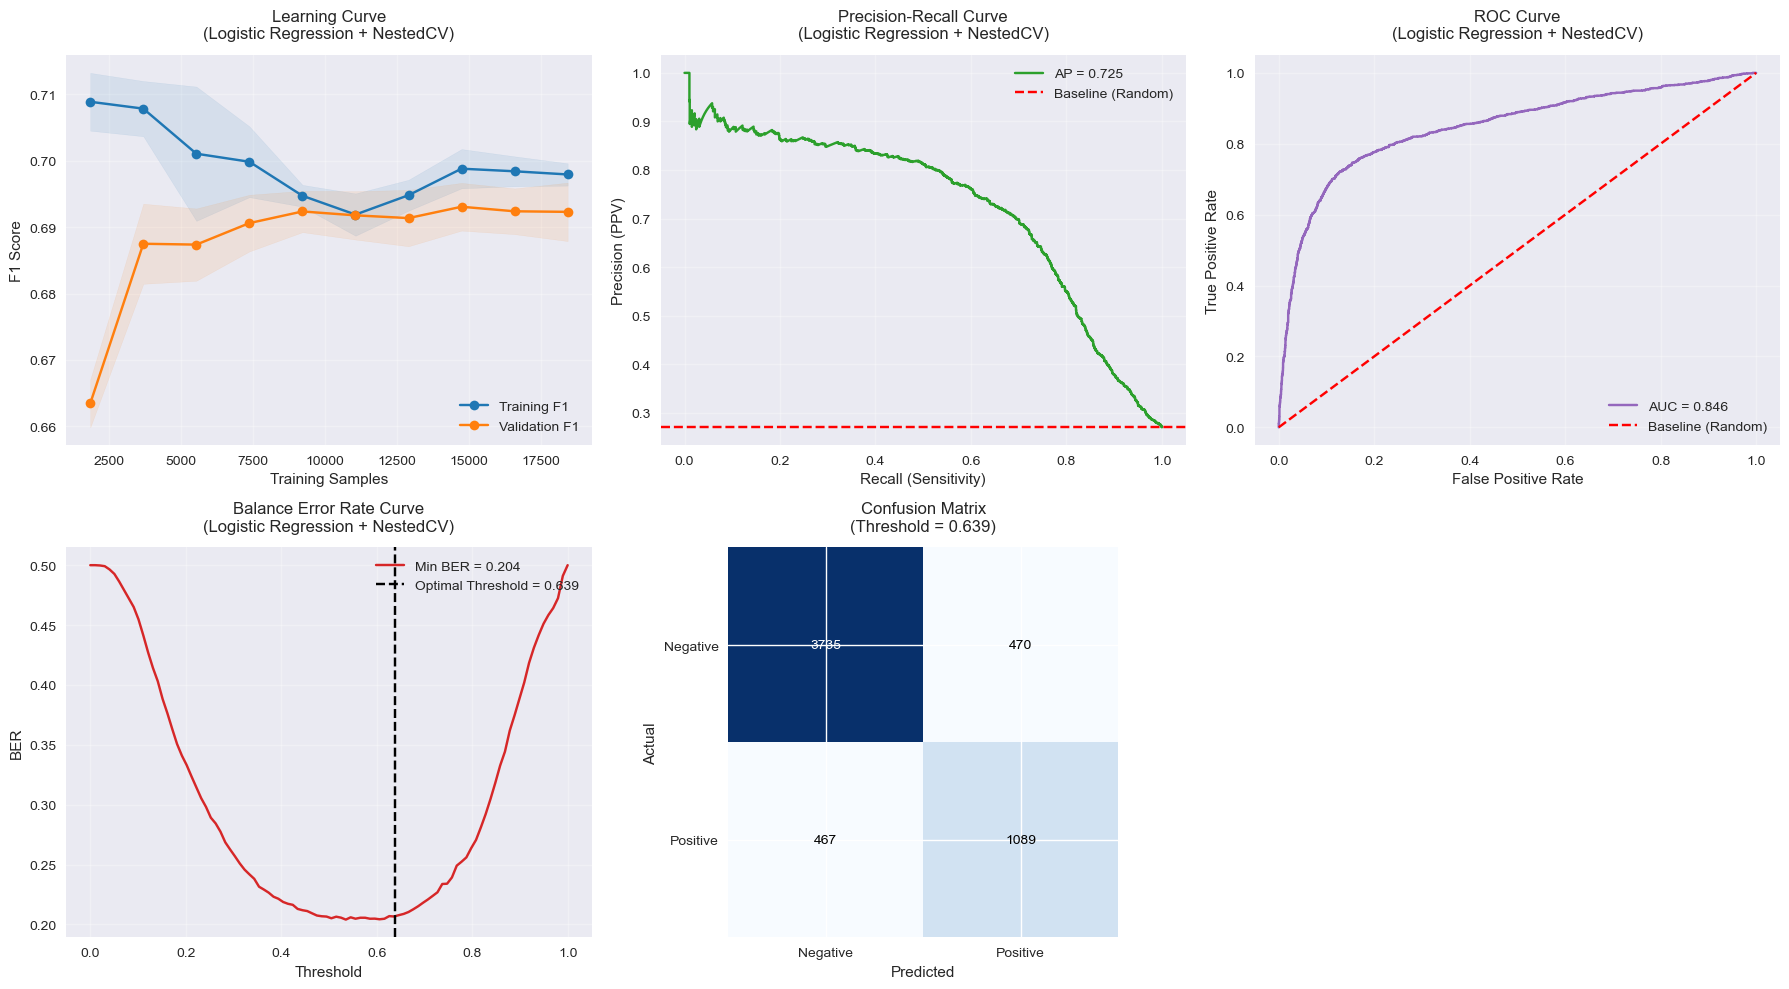


Optimal Threshold: 0.639
Max F1-Score: 0.699
Balance Error Rate (BER): 0.206
At this threshold:
- Precision = 0.699
- Recall = 0.700

Confusion Matrix:
[[3735  470]
 [ 467 1089]]


In [114]:
plot_model_curves(
    pipeline=results_logreg['best_model'],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="Logistic Regression + NestedCV"
)


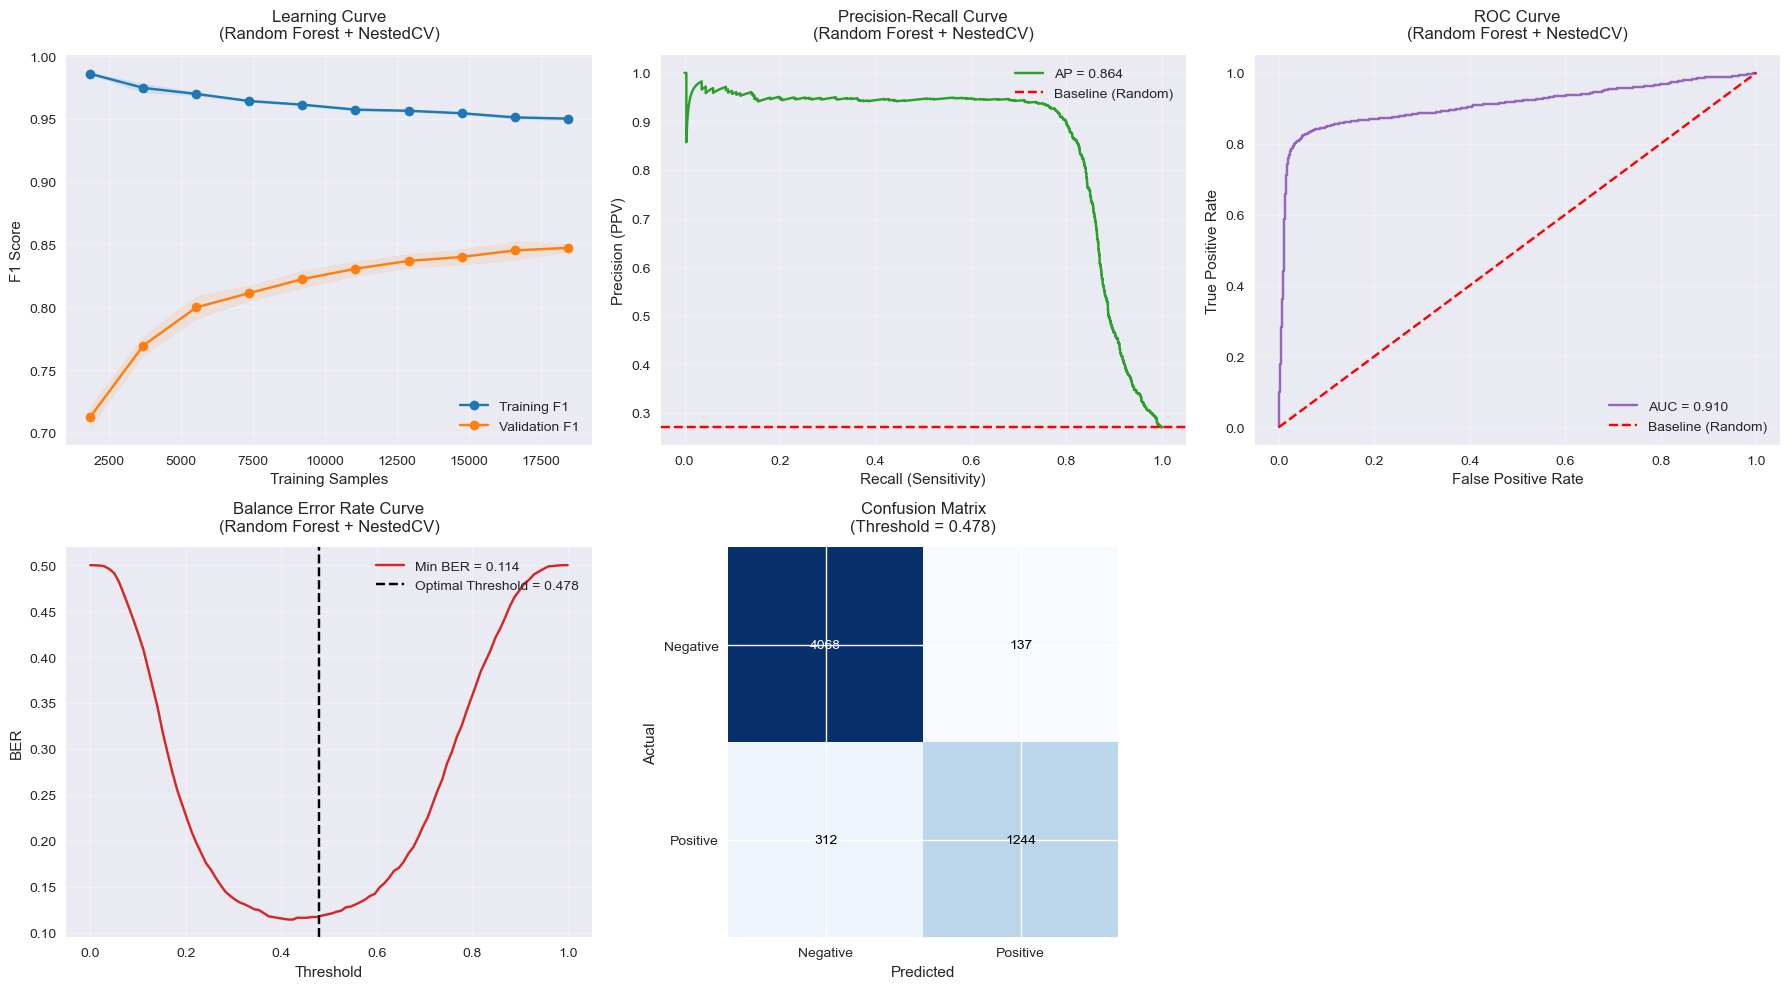


Optimal Threshold: 0.478
Max F1-Score: 0.847
Balance Error Rate (BER): 0.117
At this threshold:
- Precision = 0.901
- Recall = 0.799

Confusion Matrix:
[[4068  137]
 [ 312 1244]]


In [115]:
plot_model_curves(
    pipeline=results_rf['best_model'],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    title_prefix="Random Forest + NestedCV"
)

## 4. Technique 1
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 4.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 5. Technique 2
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 5.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 6. Comparison of metrics performance for testing

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Use of nested cross-validation for both techniques to deal with overfitting model selection and model comparison
- Use appropriate metrics for the testing set
- Use an appropriate model selection visualisation curve (ROC, PR, etc.) that is suitable for the problem at hand
- Checking for overfitting

## 7. Final recommendation of the best model

**Create a new subheading for each item you discuss from the following items.**

- Technical perspective- overfitting discussion, complexity and efficiency
- Business perspective- results interpretation, relevance and balance with a technical perspective

## 8. Conclusion

**Create a new subheading for each item you discuss from the following items.**

- What has been successfully accomplished and what has not
- Reflect back on the analysis and see what you could have done differently if you were to do the project again
- Add a wish list of future work that you would do to take the project forward
